In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np

<IPython.core.display.Javascript object>

In [3]:
def convert_to_float(value):
    try:
        # If it's a string enclosed in single quotes, remove quotes and replace comma with dot
        if isinstance(value, str):
            return float(value.replace(",", "."))
        else:
            return float(value)
    except ValueError as e:
        print(e)
        return float("nan")

<IPython.core.display.Javascript object>

In [4]:
def preprocess_numeric_cols(df, columns):
    for col in columns:
        df[col] = df[col].astype(str)  # Ensure string type for string operations
        df[col] = df[col].str.replace("#", "")  # Remove '#' characters
        df[col] = df[col].str.replace(",", ".")  # Replace ',' with '.' for decimals
    return df

<IPython.core.display.Javascript object>

In [5]:
def check_columns_match(df1, df2):
    """
    Check if two dataframes have the same columns in the same order.
    """

    df1_cols = set(df1.columns)
    df2_cols = set(df2.columns)

    same_cols = df1_cols == df2_cols

    print(f"Dataframes have the same columns: {same_cols}")

    same_order = all(df1.columns[i] == df2.columns[i] for i in range(len(df1.columns)))

    print(f"Dataframes have the same column order: {same_order}")

    return same_cols, same_order

<IPython.core.display.Javascript object>

In [6]:
innovandi = [
    "Alite total",
    "Belite total",
    "Belite alpha",
    "Belite beta",
    "Belite gamma",
    "Ferrite",
    "Aluminate",
    "Aluminate cubic",
    "Aluminate orto",
    "Free lime",
    "Portlandite",
    "Periclase",
    "Arcanite",
    "Aphthalite",
    "Langbeinite",
    "Gypsum",
    "Bassanite",
    "Anhydrite",
    "Calcite",
    "Dolimite",
    "Quartz",
    "Muscovite",
]


embrapii_cics = [
    "C3S total",
    "C2S total",
    "C2S alpha",
    "C2S beta",
    "C2S gama",
    "C4AF",
    "C3A",
    "C3A cubic",
    "C3A orto",
    "CaO livre",
    "Portlandita",
    "Periclasio",
    "Arcanita",
    "Aphthalita",
    "Langbeinita",
    "Sulfato de cálcio",
    "Bassanita",
    "Anidrita",
    "Calcita",
    "Dolimita",
    "Quartzo",
    "Muscovita",
]
mineral_map = dict(zip(innovandi, embrapii_cics))

<IPython.core.display.Javascript object>

# 203

## Reading the dataset

In [7]:
plants = ["AV", "C", "D", "G", "M", "Y"]
xls_files = {}

for plant in plants:
    xls = pd.ExcelFile(
        f"../../../data/raw/203/EMBRAPII hubIC IACC_CIMENTO_{plant}.xlsx",
        engine="openpyxl",
    )
    xls_files[plant] = xls

<IPython.core.display.Javascript object>

In [8]:
dataframes = []

for plant, xls in xls_files.items():
    for sheet_name in xls.sheet_names[1:]:
        df = pd.read_excel(xls_files[plant], sheet_name, header=[0, 1, 2])
        dataframes.append(df.drop([0, 1], axis=0).reset_index(drop=True).copy())

<IPython.core.display.Javascript object>

In [9]:
for plant, xls in xls_files.items():
    print("Plant: ", plant, xls.sheet_names)

Plant:  AV ['INSTRUÇÕES', '122', '24', '134', '50']
Plant:  C ['INSTRUÇÕES', '114', '36', '144', '74', '54']
Plant:  D ['INSTRUÇÕES', '10', '131', '117', '197', '8']
Plant:  G ['INSTRUÇÕES', '3', '160', '49', '137', '2', '17', '142']
Plant:  M ['INSTRUÇÕES', '147', '141', '159', '73', '170', '53', '135', '67', '161']
Plant:  Y ['INSTRUÇÕES', '77', '151', '179', '136', '71', '113']


<IPython.core.display.Javascript object>

In [10]:
df = pd.concat(dataframes, axis=0).reset_index(drop=True)

<IPython.core.display.Javascript object>

## Initial Preprocessing

In [11]:
df = pd.concat(
    [
        df["Dados iniciais"],
        df["Cimento"]["Análise química"],
        df["Característias físicas do cimento"],
        df["Propriedades do cimento"],
    ],
    axis=1,
)

<IPython.core.display.Javascript object>

### 1. Dropping columns where either there is no data nor it contributes to the analysis
### 2. Renaming columns to a short identifiable name 

In [12]:
COLUMNS_TO_DROP = [
    ("Data", "Produção"),
    ("Horário", "Produção"),
    ("Horário", "Medida"),
    ("Obs.", "Unnamed: 148_level_2"),
    ("Tipo de cimento", "Unnamed: 6_level_2"),
    ("Classe de resistência", "Unnamed: 7_level_2"),
    ("Obs.", "Unnamed: 8_level_2"),
    "Obs.",
    ("Obs.", "Unnamed: 148_level_2"),
    ("Unnamed: 141_level_1", "Obs."),
]

COLUMNS_TO_RENAME = {
    ("Cidade", "Unnamed: 1_level_2"): "Plant",
    ("Data", "Medida"): "Date",
    ("Unnamed: 136_level_1", "Blaine"): "Blaine",
    ("Unnamed: 137_level_1", "#200"): "#200",
    ("Unnamed: 138_level_1", "#325"): "#325",
    ("Unnamed: 139_level_1", "#400"): "#400",
    ("Unnamed: 140_level_1", "Massa específica"): "Specific Gravity",
    ("Tempo de pega", "Fim"): "Final setting time",
    ("Tempo de pega", "Inicio"): "Initial setting time",
    ("Resistência à compressão", "1 d"): "CS1",
    ("Resistência à compressão", "3 d"): "CS3",
    ("Resistência à compressão", "7 d"): "CS7",
    ("Resistência à compressão", "28 d"): "CS28",
    "Perda ao fogo": "Loss on Ignition",
    "Resíduo insolúvel": "Insoluble Residue",
}

<IPython.core.display.Javascript object>

### Defining a single variable to identify Cement Type

In [13]:
df["Cement_Type"] = (
    df[
        [
            ("Tipo de cimento", "Unnamed: 6_level_2"),
            ("Classe de resistência", "Unnamed: 7_level_2"),
            ("Obs.", "Unnamed: 8_level_2"),
        ]
    ]
    .fillna("")
    .astype(str)
    .sum(axis=1)
)

<IPython.core.display.Javascript object>

### Replacing the current cement type categories for a short identifiable category

In [14]:
# Preprocessing
df["Cement_Type"] = df["Cement_Type"].replace("FIBROCMENTO", "Fibrocimento")
df["Cement_Type"] = df["Cement_Type"].replace("CP VARIEnsacado", "CP VARI")
df["Cement_Type"] = df["Cement_Type"].replace("CP VARIGranel", "CP VARI")
df["Cement_Type"] = df["Cement_Type"].replace("CP III40Ensacado", "CP III40")
df["Cement_Type"] = df["Cement_Type"].replace("CP III40Granel", "CP III40")
df["Cement_Type"] = df["Cement_Type"].replace("CP VARIRS", "CP VARI")

<IPython.core.display.Javascript object>

### Dropping and rename the columns defined above

In [15]:
df = df.drop(COLUMNS_TO_DROP, axis=1).rename(COLUMNS_TO_RENAME, axis=1).copy()
df = df.infer_objects()

<IPython.core.display.Javascript object>

### Clean and converting numeric columns to float

In [16]:
NUMERIC_COLUMNS = [
    "CaO",
    "MgO",
    "Na2O",
    "Al2O3",
    "SiO2",
    "SO3",
    "K2O",
    "TiO2",
    "Fe2O3",
    "Loss on Ignition",
    "Insoluble Residue",
    "Blaine",
    "#200",
    "#325",
    "Specific Gravity",
    "Final setting time",
    "Initial setting time",
    "CS1",
    "CS3",
    "CS7",
    "CS28",
]

df[NUMERIC_COLUMNS] = df[NUMERIC_COLUMNS].map(convert_to_float)

could not convert string to float: '-'
could not convert string to float: '-'
could not convert string to float: '-'
could not convert string to float: '-'
could not convert string to float: '-'
could not convert string to float: '-'
could not convert string to float: '-'
could not convert string to float: '-'
could not convert string to float: '1..10'
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: '             '
could not convert string to float: '  '
could not convert string to float: ' '
could not convert string to float: '1.6.0'
could not convert string to float: '-'
could not convert string to float: '-'
could not convert string to float: '-'
could not convert string to float: '-'
could not convert string to float: '-'
could not convert string to float: '-'
could not convert string to float: '-'
could not convert string to float: '-'
could not convert string to float: '-'
coul

<IPython.core.display.Javascript object>

### Converting Date columns to pandas datetime

In [17]:
df["Date"] = pd.to_datetime(df["Date"])

<IPython.core.display.Javascript object>

In [18]:
df.shape

(20203, 25)

<IPython.core.display.Javascript object>

## Dropping missing features

### Drop rows completely missing

In [19]:
index_to_keep = (
    df.drop(["Plant", "Date", "Cement_Type"], axis=1).dropna(axis=0, how="all").index
)
df = df.iloc[index_to_keep].reset_index(drop=True)

<IPython.core.display.Javascript object>

In [20]:
df.shape

(19506, 25)

<IPython.core.display.Javascript object>

### Dropping variable with Plant identification

In [21]:
df["Factory_Plant"] = "203_" + df["Plant"]
df = df.drop("Plant", axis=1)

<IPython.core.display.Javascript object>

In [22]:
df_203 = df.copy()

<IPython.core.display.Javascript object>

# 204

In [23]:
plants = ["A", "AB", "AE", "AQ", "AY", "F", "I", "O", "R", "T"]
xls_files = {}

for plant in plants:
    xls = pd.ExcelFile(
        f"../../../data/raw/204/EMBRAPII hubIC IACC CIMENTO_{plant}.xlsx",
        engine="openpyxl",
    )
    xls_files[plant] = xls

<IPython.core.display.Javascript object>

In [24]:
cement_types_per_plant = []
CEMENT_TYPE_COLS = ["Tipo de cimento", "Classe de resistência"]
dataframes = []

for plant, xls in xls_files.items():
    for sheet_name in xls.sheet_names[1:]:
        df = pd.read_excel(xls_files[plant], sheet_name, header=[1, 2])
        if not df[CEMENT_TYPE_COLS].iloc[2:].isna().all().all():
            cement_type = (
                df[CEMENT_TYPE_COLS]
                .loc[2:]
                .astype(str)
                .sum(axis=1)
                .str.replace(" ", "")
                .str.replace("-", "")
                .str.replace("nan", "")
                .unique()
            )

        else:
            cement_type = (
                df[[("Obs.", "Unnamed: 8_level_1")]]
                .loc[2:]
                .astype(str)
                .sum(axis=1)
                .str.replace(" ", "")
                .str.replace("-", "")
                .unique()
            )

        cement_types_per_plant.append((plant, sheet_name, cement_type))
        dataframes.append(df)

<IPython.core.display.Javascript object>

In [25]:
for plant, xls in xls_files.items():
    print("Palnt: ", plant, xls.sheet_names)

Palnt:  A ['INSTRUÇÕES', '176', '102']
Palnt:  AB ['INSTRUÇÕES', '13', '51', '173']
Palnt:  AE ['INSTRUÇÕES', '181', '109', '23']
Palnt:  AQ ['INSTRUÇÕES', 'Fibro', '7', '153', '89']
Palnt:  AY ['INSTRUÇÕES', '12']
Palnt:  F ['INSTRUÇÕES', '55', '75', '14', '91', '65']
Palnt:  I ['INSTRUÇÕES', '47', '11', '1']
Palnt:  O ['INSTRUÇÕES', '132', '81', 'FIBRO']
Palnt:  R ['INSTRUÇÕES', '21', '61']
Palnt:  T ['INSTRUÇÕES', '72', '104']


<IPython.core.display.Javascript object>

In [26]:
dataframes = []

for plant, xls in xls_files.items():
    for sheet_name in xls.sheet_names[1:]:
        df = pd.read_excel(xls_files[plant], sheet_name, header=[0, 1, 2])
        df["Unnamed: 0_level_0", "Unnamed: 0_level_1", "Unnamed: 0_level_2"] = plant
        dataframes.append(df.drop([0, 1], axis=0).reset_index(drop=True).copy())

<IPython.core.display.Javascript object>

In [27]:
df = pd.concat(dataframes, axis=0).reset_index(drop=True)

<IPython.core.display.Javascript object>

## Initial Preprocessing

In [28]:
df = pd.concat(
    [
        df["Unnamed: 0_level_0", "Unnamed: 0_level_1", "Unnamed: 0_level_2"],
        df["Dados iniciais"],
        df["Cimento"]["Análise química"],
        df["Característias físicas do cimento"],
        df["Propriedades do cimento"],
    ],
    axis=1,
)

<IPython.core.display.Javascript object>

### 1. Dropping columns where either there is no data nor it contributes to the analysis
### 2. Renaming columns to a short identifiable name

In [29]:
COLUMNS_TO_DROP = [
    ("Data", "Medida"),
    ("Horário", "Produção"),
    ("Horário", "Medida"),
    ("Obs.", "Unnamed: 148_level_2"),
    ("Tipo de cimento", "Unnamed: 6_level_2"),
    ("Classe de resistência", "Unnamed: 7_level_2"),
    ("Obs.", "Unnamed: 8_level_2"),
    "Obs.",
    ("Obs.", "Unnamed: 148_level_2"),
    ("Unnamed: 141_level_1", "Obs."),
]


COLUMNS_TO_RENAME = {
    ("Unnamed: 0_level_0", "Unnamed: 0_level_1", "Unnamed: 0_level_2"): "Plant",
    ("Cidade", "Unnamed: 1_level_2"): "City",
    ("Data", "Produção"): "Date",  # Arrumar!
    ("Unnamed: 136_level_1", "Blaine"): "Blaine",
    ("Unnamed: 137_level_1", "#200"): "#200",
    ("Unnamed: 138_level_1", "#325"): "#325",
    ("Unnamed: 139_level_1", "#400"): "#400",
    ("Unnamed: 140_level_1", "Massa específica"): "Specific Gravity",
    ("Tempo de pega", "Fim"): "Final setting time",
    ("Tempo de pega", "Inicio"): "Initial setting time",
    ("Resistência à compressão", "1 d"): "CS1",
    ("Resistência à compressão", "3 d"): "CS3",
    ("Resistência à compressão", "7 d"): "CS7",
    ("Resistência à compressão", "28 d"): "CS28",
    "Perda ao fogo": "Loss on Ignition",
    "Resíduo insolúvel": "Insoluble Residue",
}

<IPython.core.display.Javascript object>

### Defining a single variable to identify Cement Type

In [30]:
# Single variable for the Cement Type
df["Cement_Type"] = (
    df[
        [
            ("Tipo de cimento", "Unnamed: 6_level_2"),
            ("Classe de resistência", "Unnamed: 7_level_2"),
            ("Obs.", "Unnamed: 8_level_2"),
        ]
    ]
    .fillna("")
    .astype(str)
    .sum(axis=1)
)

# # Preprocessing
df["Cement_Type"] = df["Cement_Type"].replace("Fibro", "Fibrocimento")

<IPython.core.display.Javascript object>

### Dropping and rename the columns defined above

In [31]:
df = df.drop(COLUMNS_TO_DROP, axis=1).rename(COLUMNS_TO_RENAME, axis=1).copy()
df = df.drop([0]).reset_index(drop=True)
df = df.infer_objects()

<IPython.core.display.Javascript object>

### Cleaning and converting numeric columns to float

In [32]:
NUMERIC_COLUMNS = [
    "CaO",
    "MgO",
    "Na2O",
    "Al2O3",
    "SiO2",
    "SO3",
    "K2O",
    "TiO2",
    "Fe2O3",
    "Loss on Ignition",
    "Insoluble Residue",
    "Blaine",
    "#200",
    "#325",
    "#400",
    "Specific Gravity",
    "Final setting time",
    "Initial setting time",
    "CS1",
    "CS3",
    "CS7",
    "CS28",
]

df = preprocess_numeric_cols(df, NUMERIC_COLUMNS)

# Preprocessing to fix numeric columns
df[NUMERIC_COLUMNS] = df[NUMERIC_COLUMNS].map(convert_to_float)

# Converting Date to pandas datetime
df["Date"] = pd.to_datetime(df["Date"])

# Drop rows completely missing
index_to_keep = (
    df.drop(["Plant", "Date", "Cement_Type"], axis=1).dropna(axis=0, how="all").index
)
df = df.iloc[index_to_keep].reset_index(drop=True)

df = df.infer_objects()

<IPython.core.display.Javascript object>

### Dropping variable with City and Plant identification

In [33]:
df["Factory_Plant"] = "204_" + df["Plant"]
FEATRUES_TO_DROP = ["City", "Plant"]
df = df.drop(labels=FEATRUES_TO_DROP, axis=1)

<IPython.core.display.Javascript object>

In [34]:
df.shape

(16000, 25)

<IPython.core.display.Javascript object>

In [35]:
df_204 = df.copy()

<IPython.core.display.Javascript object>

In [36]:
check_columns_match(df_203, df_204)

Dataframes have the same columns: True
Dataframes have the same column order: True


(True, True)

<IPython.core.display.Javascript object>

# 206

In [37]:
plant = "B"
xls_files = {}


xls = pd.ExcelFile(
    f"../../../data/raw/206/EMBRAPII hubIC IACC_CIMENTO_{plant}.xlsx",
    engine="openpyxl",
)
xls_files[plant] = xls

<IPython.core.display.Javascript object>

In [38]:
print("Plant: ", plant, xls.sheet_names)

Plant:  B ['127', '90', 'RX']


<IPython.core.display.Javascript object>

In [39]:
cement_types_per_plant = []
CEMENT_TYPE_COLS = ["Tipo de cimento", "Classe de resistência"]
dataframes = []

for plant, xls in xls_files.items():
    for sheet_name in xls.sheet_names:
        if sheet_name == "RX":
            continue
        df = pd.read_excel(xls_files[plant], sheet_name, header=[1, 2])

        if not df[CEMENT_TYPE_COLS].iloc[2:].isna().all().all():
            cement_type = (
                df[CEMENT_TYPE_COLS]
                .loc[3:]
                .astype(str)
                .sum(axis=1)
                .str.replace(" ", "")
                .str.replace("-", "")
                .str.replace("nan", "")
                .unique()
            )

        else:
            cement_type = (
                df[[("Obs.", "Unnamed: 8_level_1")]]
                .loc[3:]
                .astype(str)
                .sum(axis=1)
                .str.replace(" ", "")
                .str.replace("-", "")
                .unique()
            )

        cement_types_per_plant.append((plant, sheet_name, cement_type))
        dataframes.append(df)

<IPython.core.display.Javascript object>

In [40]:
dataframes = []

for plant, xls in xls_files.items():
    for sheet_name in xls.sheet_names:
        if sheet_name == "RX":
            continue
        df = pd.read_excel(xls_files[plant], sheet_name, header=[0, 1, 2])
        df["Unnamed: 0_level_0", "Unnamed: 0_level_1", "Unnamed: 0_level_2"] = plant
        dataframes.append(df.drop([0, 1], axis=0).reset_index(drop=True).copy())

<IPython.core.display.Javascript object>

In [41]:
df = pd.concat(dataframes, axis=0).reset_index(drop=True)

<IPython.core.display.Javascript object>

## Initial Preprocessing

In [42]:
df = pd.concat(
    [
        df["Unnamed: 0_level_0", "Unnamed: 0_level_1", "Unnamed: 0_level_2"],
        df["Dados iniciais"],
        df["Cimento"]["Análise química"],
        df["Característias físicas do cimento"],
        df["Propriedades do cimento"],
    ],
    axis=1,
)

<IPython.core.display.Javascript object>

### 1. Dropping columns where either there is no data nor it contributes to the analysis
### 2. Renaming columns to a short identifiable name

In [43]:
COLUMNS_TO_DROP = [
    ("Data", "Medida"),
    ("Horário", "Produção"),
    ("Horário", "Medida"),
    ("Cidade", "Unnamed: 1_level_2"),
    ("Tipo de cimento", "Unnamed: 6_level_2"),
    ("Classe de resistência", "Unnamed: 7_level_2"),
    ("Unnamed: 83_level_1", "Obs."),
    ("Obs.", "Unnamed: 8_level_2"),
    ("Obs.", "Unnamed: 90_level_2"),
    "Obs.",
]

COLUMNS_TO_RENAME = {
    ("Unnamed: 0_level_0", "Unnamed: 0_level_1", "Unnamed: 0_level_2"): "Plant",
    ("Cidade", "Unnamed: 1_level_2"): "City",
    ("Data", "Produção"): "Date",
    ("Unnamed: 78_level_1", "Blaine"): "Blaine",
    ("Unnamed: 79_level_1", "#200"): "#200",
    ("Unnamed: 80_level_1", "#325"): "#325",
    ("Unnamed: 81_level_1", "#400"): "#400",
    ("Unnamed: 82_level_1", "Massa específica"): "Specific Gravity",
    ("Tempo de pega", "Inicio"): "Initial setting time",
    ("Tempo de pega", "Fim"): "Final setting time",
    ("Resistência à compressão", "1 d"): "CS1",
    ("Resistência à compressão", "3 d"): "CS3",
    ("Resistência à compressão", "7 d"): "CS7",
    ("Resistência à compressão", "28 d"): "CS28",
    "Perda ao fogo": "Loss on Ignition",
    "Resíduo insolúvel": "Insoluble Residue",
}

<IPython.core.display.Javascript object>

### Defining a single variable to identify Cement Type

In [44]:
# Single variable for the Cement Type
df["Cement_Type"] = (
    df[
        [
            ("Tipo de cimento", "Unnamed: 6_level_2"),
            ("Classe de resistência", "Unnamed: 7_level_2"),
            ("Obs.", "Unnamed: 8_level_2"),
        ]
    ]
    .fillna("")
    .astype(str)
    .sum(axis=1)
)

<IPython.core.display.Javascript object>

### Dropping and rename the columns defined above

In [45]:
df = df[(df["Cement_Type"] != "ManualManual")]
df = df.drop(COLUMNS_TO_DROP, axis=1).rename(COLUMNS_TO_RENAME, axis=1).copy()
df = df.infer_objects()

<IPython.core.display.Javascript object>

### Cleaning and converting numeric columns to float

In [46]:
NUMERIC_COLUMNS = [
    "CaO",
    "MgO",
    "Na2O",
    "Al2O3",
    "SiO2",
    "SO3",
    "K2O",
    "TiO2",
    "Fe2O3",
    "Loss on Ignition",
    "Insoluble Residue",
    "Blaine",
    "#200",
    "#325",
    "#400",
    "Specific Gravity",
    "Final setting time",
    "Initial setting time",
    "CS1",
    "CS3",
    "CS7",
    "CS28",
]

df = preprocess_numeric_cols(df, NUMERIC_COLUMNS)

# Preprocessing to fix numeric columns
df[NUMERIC_COLUMNS] = df[NUMERIC_COLUMNS].map(convert_to_float)

# Converting Date to pandas datetime
df["Date"] = pd.to_datetime(df["Date"])

df = df.reset_index(drop=True)
# Drop rows completely missing
index_to_keep = (
    df.drop(["Plant", "Date", "Cement_Type"], axis=1).dropna(axis=0, how="all").index
)
df = df.iloc[index_to_keep].reset_index(drop=True)

df = df.infer_objects()

<IPython.core.display.Javascript object>

## Dropping missing features

In [47]:
index_to_keep = (
    df.drop(["Plant", "Date", "Cement_Type"], axis=1).dropna(axis=0, how="all").index
)
df = df.iloc[index_to_keep].reset_index(drop=True)

<IPython.core.display.Javascript object>

### Dropping variable with Plant identification

In [48]:
df["Factory_Plant"] = "206_" + df["Plant"]
df = df.drop("Plant", axis=1)

<IPython.core.display.Javascript object>

In [49]:
df_206 = df.copy()

<IPython.core.display.Javascript object>

In [50]:
check_columns_match(df_203, df_204)

Dataframes have the same columns: True
Dataframes have the same column order: True


(True, True)

<IPython.core.display.Javascript object>

In [51]:
check_columns_match(df_203, df_206)

Dataframes have the same columns: True
Dataframes have the same column order: True


(True, True)

<IPython.core.display.Javascript object>

# 207

In [52]:
plant = "AT"
xls_files = {}

xls = pd.ExcelFile(
    f"../../../data/raw/207/EMBRAPII hubIC IACC_CIMENTO_{plant}.xlsx",
    engine="openpyxl",
)
xls_files[plant] = xls

<IPython.core.display.Javascript object>

In [53]:
print("Plant: ", plant, xls.sheet_names)

Plant:  AT ['INSTRUÇÕES', '98', '195', '5']


<IPython.core.display.Javascript object>

In [54]:
cement_types_per_plant = []
CEMENT_TYPE_COLS = ["Tipo de cimento", "Classe de resistência"]
dataframes = []

for plant, xls in xls_files.items():
    for sheet_name in xls.sheet_names[1:]:
        df = pd.read_excel(xls_files[plant], sheet_name, header=[1, 2])
        if not df[CEMENT_TYPE_COLS].iloc[2:].isna().all().all():
            cement_type = (
                df[CEMENT_TYPE_COLS]
                .loc[2:]
                .astype(str)
                .sum(axis=1)
                .str.replace(" ", "")
                .str.replace("-", "")
                .str.replace("nan", "")
                .unique()
            )

        else:
            cement_type = (
                df[[("Obs.", "Unnamed: 8_level_1")]]
                .loc[2:]
                .astype(str)
                .sum(axis=1)
                .str.replace(" ", "")
                .str.replace("-", "")
                .unique()
            )

        cement_types_per_plant.append((plant, sheet_name, cement_type))
        dataframes.append(df)

<IPython.core.display.Javascript object>

In [55]:
dataframes = []

for plant, xls in xls_files.items():
    for sheet_name in xls.sheet_names[1:]:
        df = pd.read_excel(xls_files[plant], sheet_name, header=[0, 1, 2])
        df["Unnamed: 0_level_0", "Unnamed: 0_level_1", "Unnamed: 0_level_2"] = plant
        dataframes.append(df.drop([0, 1], axis=0).reset_index(drop=True).copy())

<IPython.core.display.Javascript object>

In [56]:
df = pd.concat(dataframes, axis=0).reset_index(drop=True)

<IPython.core.display.Javascript object>

## Initial Preprocessing

In [57]:
df = pd.concat(
    [
        df["Unnamed: 0_level_0", "Unnamed: 0_level_1", "Unnamed: 0_level_2"],
        df["Dados iniciais"],
        df["Cimento"]["Análise química"],
        df["Característias físicas do cimento"],
        df["Propriedades do cimento"],
    ],
    axis=1,
)

<IPython.core.display.Javascript object>

### 1. Dropping columns where either there is no data nor it contributes to the analysis
### 2. Renaming columns to a short identifiable name

In [58]:
COLUMNS_TO_DROP = [
    ("Data", "Medida"),
    ("Horário", "Produção"),
    ("Horário", "Medida"),
    ("Obs.", "Unnamed: 148_level_2"),
    ("Tipo de cimento", "Unnamed: 6_level_2"),
    ("Classe de resistência", "Unnamed: 7_level_2"),
    ("Obs.", "Unnamed: 8_level_2"),
    "Obs.",
    ("Obs.", "Unnamed: 148_level_2"),
    ("Unnamed: 141_level_1", "Obs."),
]

COLUMNS_TO_RENAME = {
    ("Unnamed: 0_level_0", "Unnamed: 0_level_1", "Unnamed: 0_level_2"): "Plant",
    ("Cidade", "Unnamed: 1_level_2"): "City",
    ("Data", "Produção"): "Date",  # Arrumar!
    ("Unnamed: 136_level_1", "Blaine"): "Blaine",
    ("Unnamed: 137_level_1", "#200"): "#200",
    ("Unnamed: 138_level_1", "#325"): "#325",
    ("Unnamed: 139_level_1", "#400"): "#400",
    ("Unnamed: 140_level_1", "Massa específica"): "Specific Gravity",
    ("Tempo de pega", "Inicio"): "Initial setting time",
    ("Tempo de pega", "Fim"): "Final setting time",
    ("Resistência à compressão", "1 d"): "CS1",
    ("Resistência à compressão", "3 d"): "CS3",
    ("Resistência à compressão", "7 d"): "CS7",
    ("Resistência à compressão", "28 d"): "CS28",
    "Perda ao fogo": "Loss on Ignition",
    "Resíduo insolúvel": "Insoluble Residue",
}

<IPython.core.display.Javascript object>

### Defining a single variable to identify Cement Type

In [59]:
# Single variable for the Cement Type
df["Cement_Type"] = (
    df[
        [
            ("Tipo de cimento", "Unnamed: 6_level_2"),
            ("Classe de resistência", "Unnamed: 7_level_2"),
            ("Obs.", "Unnamed: 8_level_2"),
        ]
    ]
    .fillna("")
    .astype(str)
    .sum(axis=1)
)

# # Preprocessing
df["Cement_Type"] = df["Cement_Type"].replace("Fibro", "Fibrocimento")

<IPython.core.display.Javascript object>

### Dropping and rename the columns defined above

In [60]:
df = df.drop(COLUMNS_TO_DROP, axis=1).rename(COLUMNS_TO_RENAME, axis=1).copy()
df = df.drop([0]).reset_index(drop=True)
df = df.infer_objects()

<IPython.core.display.Javascript object>

### Cleaning and converting numeric columns to float

In [61]:
NUMERIC_COLUMNS = [
    "CaO",
    "MgO",
    "Na2O",
    "Al2O3",
    "SiO2",
    "SO3",
    "K2O",
    "TiO2",
    "Fe2O3",
    "Loss on Ignition",
    "Insoluble Residue",
    "Blaine",
    "#200",
    "#325",
    "#400",
    "Specific Gravity",
    "Final setting time",
    "Initial setting time",
    "CS1",
    "CS3",
    "CS7",
    "CS28",
]

df = preprocess_numeric_cols(df, NUMERIC_COLUMNS)

# Preprocessing to fix numeric columns
df[NUMERIC_COLUMNS] = df[NUMERIC_COLUMNS].map(convert_to_float)

# Converting Date to pandas datetime
df["Date"] = pd.to_datetime(df["Date"])

# Drop rows completely missing
index_to_keep = (
    df.drop(["Plant", "Date", "Cement_Type"], axis=1).dropna(axis=0, how="all").index
)

# Filling with cement type due problems with given excel file
index = df[df["Cement_Type"] == ""].index
df.loc[index, "Cement_Type"] = "CPVARI"

df = df.iloc[index_to_keep].reset_index(drop=True)

df = df.infer_objects()

<IPython.core.display.Javascript object>

## Dropping missing features

### Drop rows completely missing

In [62]:
index_to_keep = (
    df.drop(["Plant", "City", "Date", "Cement_Type"], axis=1)
    .dropna(axis=0, how="all")
    .index
)
df = df.iloc[index_to_keep].reset_index(drop=True)

<IPython.core.display.Javascript object>

In [63]:
df.shape

(3002, 26)

<IPython.core.display.Javascript object>

### Dropping variable with Plant identification

In [64]:
df["Factory_Plant"] = "207_" + df["Plant"]
df = df.drop(["Plant", "City"], axis=1)

<IPython.core.display.Javascript object>

In [65]:
df_207 = df.copy()

<IPython.core.display.Javascript object>

In [66]:
check_columns_match(df_203, df_207)

Dataframes have the same columns: True
Dataframes have the same column order: True


(True, True)

<IPython.core.display.Javascript object>

In [67]:
check_columns_match(df_204, df_207)

Dataframes have the same columns: True
Dataframes have the same column order: True


(True, True)

<IPython.core.display.Javascript object>

In [68]:
check_columns_match(df_206, df_207)

Dataframes have the same columns: True
Dataframes have the same column order: True


(True, True)

<IPython.core.display.Javascript object>

# 209

In [69]:
plants = [
    "X",
    "H",
    "AS",
    "AG",
    "AW",
    "AZ",
    "W",
    "V",
    "AX",
    "L",
    "N",
    "AI",
    "AA",
    "P",
    "Q",
    "AP",
    "E",
    "AN",
    "AC",
    "K",
    "S",
    "U",
    "J",
    "AM",
    "Z",
]
xls_files = {}

for plant in plants:
    xls = pd.ExcelFile(
        f"../../../data/raw/209/EMBRAPII hubIC IACC_CIMENTO_{plant}.xlsx",
        engine="openpyxl",
    )
    xls_files[plant] = xls

<IPython.core.display.Javascript object>

In [70]:
for plant, xls in xls_files.items():
    print("Palnt: ", plant, xls.sheet_names)

Palnt:  X ['INSTRUÇÕES', 'Clínquer', '78', '83', '19']
Palnt:  H ['INSTRUÇÕES', 'Clínquer', '119', '76', '87']
Palnt:  AS ['INSTRUÇÕES', 'Clínquer', '31', '63']
Palnt:  AG ['INSTRUÇÕES', 'Clínquer', '146', '115', '166']
Palnt:  AW ['INSTRUÇÕES', 'Clínquer', '88']
Palnt:  AZ ['INSTRUÇÕES', 'Clínquer', '4', '92', '70', '111', '156']
Palnt:  W ['INSTRUÇÕES', 'Clínquer', '140', '196', '163']
Palnt:  V ['INSTRUÇÕES', 'Clínquer', '93']
Palnt:  AX ['INSTRUÇÕES', 'Clínquer', '152', '108', '118']
Palnt:  L ['INSTRUÇÕES', 'Clínquer', '6', '39', '16']
Palnt:  N ['INSTRUÇÕES', 'Clínquer', '80', '66', '94']
Palnt:  AI ['INSTRUÇÕES', 'Clínquer', '79', '27', '120']
Palnt:  AA ['INSTRUÇÕES', 'Clínquer', '95', '110', '133', '145']
Palnt:  P ['INSTRUÇÕES', 'Clínquer', '175']
Palnt:  Q ['INSTRUÇÕES', 'Clínquer', '56', '32', '101', '143']
Palnt:  AP ['INSTRUÇÕES', 'Clínquer', '191', '189', '199', '41']
Palnt:  E ['INSTRUÇÕES', 'Clínquer', '121', '178']
Palnt:  AN ['INSTRUÇÕES', 'Clínquer', '112', '172']
P

<IPython.core.display.Javascript object>

In [71]:
cement_types_per_plant = []
CEMENT_TYPE_COLS = ["Tipo de cimento", "Classe de resistência"]
dataframes = []

for plant, xls in xls_files.items():
    for sheet_name in xls.sheet_names[2:]:
        df = pd.read_excel(xls_files[plant], sheet_name, header=[1, 2])

        if not df[CEMENT_TYPE_COLS].iloc[2:].isna().all().all():
            cement_type = (
                df[CEMENT_TYPE_COLS]
                .loc[2:]
                .astype(str)
                .sum(axis=1)
                .str.replace(" ", "")
                .str.replace("-", "")
                .str.replace("nan", "")
                .unique()
            )

        else:
            cement_type = (
                df[[("Obs.", "Unnamed: 8_level_1")]]
                .loc[2:]
                .astype(str)
                .sum(axis=1)
                .str.replace(" ", "")
                .str.replace("-", "")
                .unique()
            )

        cement_types_per_plant.append((plant, sheet_name, cement_type))
        dataframes.append(df)

<IPython.core.display.Javascript object>

In [72]:
dataframes = []

for plant, xls in xls_files.items():
    for sheet_name in xls.sheet_names[2:]:
        df = pd.read_excel(xls_files[plant], sheet_name, header=[0, 1, 2])
        df["Unnamed: 0_level_0", "Unnamed: 0_level_1", "Unnamed: 0_level_2"] = plant
        dataframes.append(df.drop([0, 1], axis=0).reset_index(drop=True).copy())

<IPython.core.display.Javascript object>

In [73]:
df = pd.concat(dataframes, axis=0).reset_index(drop=True)

<IPython.core.display.Javascript object>

## Initial Preprocessing

In [74]:
df = pd.concat(
    [
        df["Unnamed: 0_level_0", "Unnamed: 0_level_1", "Unnamed: 0_level_2"],
        df["Dados iniciais"],
        df["Cimento"]["Composição"].rename(
            {"Sulfato de cálcio": "Sulfato de cálcio (composição)"}, axis=1
        ),
        df["Cimento"]["Análise mineralógica"],
        df["Cimento"]["Análise química"],
        df["Característias físicas do cimento"],
        df["Propriedades do cimento"],
    ],
    axis=1,
)

<IPython.core.display.Javascript object>

### 1. Dropping columns where either there is no data nor it contributes to the analysis
### 2. Renaming columns to a short identifiable name

In [75]:
COLUMNS_TO_DROP = [
    ("Data", "Medida"),
    ("Horário", "Produção"),
    ("Horário", "Medida"),
    ("Obs.", "Unnamed: 148_level_2"),
    ("Tipo de cimento", "Unnamed: 6_level_2"),
    ("Classe de resistência", "Unnamed: 7_level_2"),
    ("Obs.", "Unnamed: 8_level_2"),
    "Obs.",
    ("Obs.", "Unnamed: 148_level_2"),
    ("Unnamed: 141_level_1", "Obs."),
    # ("Unnamed: 139_level_1", "#400"),
]

COLUMNS_TO_RENAME = {
    ("Unnamed: 0_level_0", "Unnamed: 0_level_1", "Unnamed: 0_level_2"): "Plant",
    ("Cidade", "Unnamed: 1_level_2"): "City",
    ("Data", "Produção"): "Date",  # Arrumar!
    ("Unnamed: 136_level_1", "Blaine"): "Blaine",
    ("Unnamed: 137_level_1", "#200"): "#200",
    ("Unnamed: 138_level_1", "#325"): "#325",
    ("Unnamed: 139_level_1", "#400"): "#400",
    ("Unnamed: 140_level_1", "Massa específica"): "Specific Gravity",
    ("Tempo de pega", "Inicio"): "Initial setting time",
    ("Tempo de pega", "Fim"): "Final setting time",
    ("Resistência à compressão", "1 d"): "CS1",
    ("Resistência à compressão", "3 d"): "CS3",
    ("Resistência à compressão", "7 d"): "CS7",
    ("Resistência à compressão", "28 d"): "CS28",
    "Perda ao fogo": "Loss on Ignition",
    "Resíduo insolúvel": "Insoluble Residue",
    "Clínquer": "Clinker",
    "Fíler calcário": "Calcareous filler",
    "Cinza volante": "Fly ash",
    "Escória": "Slag",
    "Argila calcinada": "Calcined clay",
    "Sulfato de cálcio": "Calcium sulfate",
    "C3S total": "Total C3S",
    "C2S total": "Total C2S",
    "C2S alpha": "Alpha C2S",
    "C2S beta": "Beta C2S",
    "C2S gama": "Gamma C2S",
    "C4AF": "C4AF",
    "C3A": "C3A",
    "C3A cubic": "Cubic C3A",
    "C3A orto": "Orthorhombic C3A",
    "CaO livre": "Free CaO",
    "Portlandita": "Portlandite",
    "Periclasio": "Periclase",
    "Arcanita": "Arcanite",
    "Aphthalita": "Aphthitalite",
    "Langbeinita": "Langbeinite",
    "Bassanita": "Bassanite",
    "Anidrita": "Anhydrite",
    "Calcita": "Calcite",
    # "Dolomita": "Dolomite",
    # "Dolomite": "Dolomite",  # TODO - change on dataprep of local models!
    "Dolimita": "Dolomite",  # TODO - change on dataprep of local models!
    "Quartzo": "Quartz",
    "Muscovita": "Muscovite",
    "Sulfato de cálcio (composição)": "Calcium sulfate (composition)",
}

<IPython.core.display.Javascript object>

### Defining a single variable to identify Cement Type

In [76]:
# Single variable for the Cement Type
df["Cement_Type"] = (
    df[
        [
            ("Tipo de cimento", "Unnamed: 6_level_2"),
            ("Classe de resistência", "Unnamed: 7_level_2"),
            ("Obs.", "Unnamed: 8_level_2"),
        ]
    ]
    .fillna("")
    .astype(str)
    .sum(axis=1)
)

# # Preprocessing
df["Cement_Type"] = df["Cement_Type"].replace("Fibro", "Fibrocimento")

# Preprocessing
df["Cement_Type"] = (
    df["Cement_Type"]
    .str.replace("Expedido", "")
    .str.replace("Linha 9", "")
    .str.replace("Itajaí", "")
    .str.replace("D-G", "")
    .str.replace("D-E", "")
    .str.replace("DF2", "")
    .str.replace("CPIIF40", "CP II-F-40")
    .str.replace("CPIIF40", "CP II-F40")
    .str.replace("CP VARI", "CP V-ARI")
    .str.replace("CPVARI", "CP V-ARI")
    .str.replace("CP V-RSARI", "CP V-ARI RS")
    .str.replace("CP III-RS40", "CP III-40 RS")
    .str.replace("CP III-RS32", "CP III-32 RS")
    .str.replace("CP IV-RS32", "CP IV-32 RS")
    .str.replace("CP III40", "CP III-40")
    .str.replace("CP III32", "CP III-32")
    .str.replace("CP I-S40", "CP I-S-40")
    .str.replace("CP I40", "CP I-40")
    .str.replace("CP II-E32", "CP II-E-32")
    .str.replace("CP II-E40", "CP II-E-40")
    .str.replace("CP II-F FIBRO40", "CP II-F-40")
    .str.replace("CP II-F32", "CP II-F-32")
    .str.replace("CP II-F40", "CP II-F-40")
    .str.replace("CP II-Z32", "CP II-Z-32")
    .str.replace("CP II-Z40", "CP II-Z-40")
    .str.replace("CP IV32", "CP IV-32")
    .str.replace("CP IND", "CP I")
    .str.replace("CPINDCC", "CP I")
    .str.strip()
)

df = df.drop(COLUMNS_TO_DROP, axis=1).rename(COLUMNS_TO_RENAME, axis=1).copy()
df = df.drop([0]).reset_index(drop=True)
df = df.infer_objects()

<IPython.core.display.Javascript object>

In [77]:
df.shape

(31109, 54)

<IPython.core.display.Javascript object>

### Dropping and rename the columns defined above

### Cleaning and converting numeric columns to float

In [78]:
NUMERIC_COLUMNS = [
    "Calcium sulfate (composition)",
    "Clinker",
    "Calcareous filler",
    "Fly ash",
    "Slag",
    "Calcined clay",
    "Calcium sulfate",
    "Total C3S",
    "Total C2S",
    "Alpha C2S",
    "Beta C2S",
    "Gamma C2S",
    "C4AF",
    "C3A",
    "Cubic C3A",
    "Orthorhombic C3A",
    "Free CaO",
    "Portlandite",
    "Periclase",
    "Arcanite",
    "Aphthitalite",
    "Langbeinite",
    "Bassanite",
    "Anhydrite",
    "Calcite",
    "Dolomite",
    "Quartz",
    "Muscovite",
    "CaO",
    "MgO",
    "Na2O",
    "Al2O3",
    "SiO2",
    "SO3",
    "K2O",
    "TiO2",
    "Fe2O3",
    "Loss on Ignition",
    "Insoluble Residue",
    "Blaine",
    "#200",
    "#325",
    "#400",
    "Specific Gravity",
    "Final setting time",
    "Initial setting time",
    "CS1",
    "CS3",
    "CS7",
    "CS28",
]

df = preprocess_numeric_cols(df, NUMERIC_COLUMNS)

# Preprocessing to fix numeric columns
df[NUMERIC_COLUMNS] = df[NUMERIC_COLUMNS].map(convert_to_float)

# Converting Date to pandas datetime
df["Date"] = pd.to_datetime(df["Date"])

# Drop rows completely missing
index_to_keep = (
    df.drop(["Plant", "Date", "Cement_Type"], axis=1).dropna(axis=0, how="all").index
)
df = df.iloc[index_to_keep].reset_index(drop=True)

df = df.infer_objects()

could not convert string to float: '-'
could not convert string to float: '-'
could not convert string to float: '-'
could not convert string to float: '-'
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: '-'
could not convert string to float: '-'
could not convert string to float: '-'
could not convert string to float: '-'
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string 

could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string 

could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string 

<IPython.core.display.Javascript object>

## Dropping missing features

### Drop rows completely missing

In [79]:
index_to_keep = (
    df.drop(["Plant", "City", "Date", "Cement_Type"], axis=1)
    .dropna(axis=0, how="all")
    .index
)
df = df.iloc[index_to_keep].reset_index(drop=True)

<IPython.core.display.Javascript object>

In [80]:
df.shape

(31035, 54)

<IPython.core.display.Javascript object>

### Dropping variable with Plant identification

In [81]:
df["Factory_Plant"] = "209_" + df["Plant"]
df = df.drop(["Plant", "City"], axis=1)

<IPython.core.display.Javascript object>

In [82]:
df_209 = df.copy()

<IPython.core.display.Javascript object>

### Fixing Column ordering:

In [83]:
EXTRA_COLS_209 = [
    "Clinker",
    "Calcareous filler",
    "Fly ash",
    "Slag",
    "Calcined clay",
    "Calcium sulfate (composition)",
    "Total C3S",
    "Total C2S",
    "Alpha C2S",
    "Beta C2S",
    "Gamma C2S",
    "C4AF",
    "C3A",
    "Cubic C3A",
    "Orthorhombic C3A",
    "Free CaO",
    "Portlandite",
    "Periclase",
    "Arcanite",
    "Aphthitalite",
    "Langbeinite",
    "Calcium sulfate",
    "Bassanite",
    "Anhydrite",
    "Calcite",
    "Dolomite",
    "Quartz",
    "Muscovite",
]

<IPython.core.display.Javascript object>

In [84]:
USUAL_COLS_209 = [
    col for col in filter(lambda c: c not in EXTRA_COLS_209, df_209.columns)
]

<IPython.core.display.Javascript object>

In [85]:
df_209 = pd.concat([df_209[USUAL_COLS_209], df_209[EXTRA_COLS_209]], axis=1)

<IPython.core.display.Javascript object>

In [86]:
check_columns_match(df_203, df_209[USUAL_COLS_209])

Dataframes have the same columns: True
Dataframes have the same column order: True


(True, True)

<IPython.core.display.Javascript object>

# partner_ii

In [87]:
df = pd.read_csv("../../../data/raw/partner_ii/db3_cement.csv")

<IPython.core.display.Javascript object>

## Initial Preprocessing

### 1. Dropping columns where either there is no data nor it contributes to the analysis
### 2. Renaming columns to a short identifiable name

In [88]:
COLUMNS_TO_DROP = [
    "sample_id_plant",
    "raw_material_code",
    "water_demand",
]

COLUMNS_TO_RENAME = {
    "sample_date": "Date",
    "unified_material_name": "Cement_Type",
    "cao": "CaO",
    "sio2": "SiO2",
    "al2o3": "Al2O3",
    "fe2o3": "Fe2O3",
    "mgo": "MgO",
    "so3": "SO3",
    "k2o": "K2O",
    "na2o": "Na2O",
    # "cl": "Cl-",
    "cl": "Cl",
    "tio2": "TiO2",
    "alite": "Alite",
    "belite": "Belite",
    "aluminate": "Aluminate",
    "ferrite": "Ferrite",
    "free_lime": "Free CaO",
    "loi": "Loss on Ignition",
    "water_demand": "Water Demand",
    "setting_initial": "Initial setting time",
    "strength_1d": "CS1",
    "strength_3d": "CS3",
    "strength_7d": "CS7",
    "strength_28d": "CS28",
    "blaine": "Blaine",
    # "sieve_32um": "#400",
    # "sieve_45um": "#325",
    "sieve_32um": "Sieve 32 um",
    "sieve_45um": "Sieve 45 um",
}

<IPython.core.display.Javascript object>

In [89]:
COLUMNS_TO_RENAME_2 = {
    "Alite": "Total C3S",
    "Belite": "Total C2S",
    "Aluminate": "C3A",
    "Ferrite": "C4AF",
}

<IPython.core.display.Javascript object>

### Defining a single variable to identify Cement Type

### Dropping and rename the columns defined above

In [90]:
df = (
    df.drop(COLUMNS_TO_DROP, axis=1)
    .rename(COLUMNS_TO_RENAME, axis=1)
    .rename(COLUMNS_TO_RENAME_2, axis=1)
    .copy()
)
df = df.drop([0]).reset_index(drop=True)
df = df.infer_objects()

<IPython.core.display.Javascript object>

### Cleaning and converting numeric columns to float

In [91]:
NUMERIC_COLUMNS = [
    "CaO",
    "SiO2",
    "Al2O3",
    "Fe2O3",
    "MgO",
    "SO3",
    "K2O",
    "Na2O",
    # "Cl-",
    "Cl",
    "TiO2",
    # "Alite",
    # "Belite",
    # "Aluminate",
    # "Ferrite",
    "Total C3S",
    "Total C2S",
    "C3A",
    "C4AF",
    "Free CaO",
    "Loss on Ignition",
    "Initial setting time",
    "CS1",
    "CS3",
    "CS7",
    "CS28",
    "Blaine",
    # "#400",
    # "#325",
]

df = preprocess_numeric_cols(df, NUMERIC_COLUMNS)

# Preprocessing to fix numeric columns
df[NUMERIC_COLUMNS] = df[NUMERIC_COLUMNS].map(convert_to_float)

# Converting Date to pandas datetime
df["Date"] = pd.to_datetime(df["Date"])

# Drop rows completely missing
index_to_keep = df.drop(["Date", "Cement_Type"], axis=1).dropna(axis=0, how="all").index
df = df.iloc[index_to_keep].reset_index(drop=True)

df = df.infer_objects()

<IPython.core.display.Javascript object>

## Dropping missing features

### Drop rows completely missing

In [92]:
index_to_keep = df.drop(["Date", "Cement_Type"], axis=1).dropna(axis=0, how="all").index
df = df.iloc[index_to_keep].reset_index(drop=True)

<IPython.core.display.Javascript object>

In [93]:
df.shape

(36818, 26)

<IPython.core.display.Javascript object>

### Dropping variable with Plant identification

In [94]:
df["Factory_Plant"] = "partner_ii"

<IPython.core.display.Javascript object>

#### Removing the timezone

In [95]:
df["Date"].dtype

datetime64[ns, UTC]

<IPython.core.display.Javascript object>

In [96]:
df["Date"] = df["Date"].dt.tz_localize(None)

<IPython.core.display.Javascript object>

In [97]:
df["Date"].dtype

dtype('<M8[ns]')

<IPython.core.display.Javascript object>

In [98]:
df_heildelberg = df.copy()

<IPython.core.display.Javascript object>

# partner_iv (skipped)

In [99]:
import datetime as dt

<IPython.core.display.Javascript object>

In [100]:
xlsx = pd.ExcelFile(
    "../../../data/raw/partner_iv/DB_Master_CP1_latest.xlsx", engine="openpyxl"
)

<IPython.core.display.Javascript object>

In [101]:
df_cem_a = pd.read_excel(xlsx, sheet_name="Cem A exp control", skiprows=[1, 2])
df_cem_a = df_cem_a[
    [col for col in df_cem_a.columns.fillna("Unnamed") if "Unnamed" not in col]
]

df_cem_b = pd.read_excel(xlsx, sheet_name="Cem B exp control", skiprows=[1, 2])
df_cem_b = df_cem_b[
    [col for col in df_cem_b.columns.fillna("Unnamed") if "Unnamed" not in col]
]

df_cem_c = pd.read_excel(xlsx, sheet_name="Cem c exp control", skiprows=[1, 2])
df_cem_c = df_cem_c[
    [col for col in df_cem_c.columns.fillna("Unnamed") if "Unnamed" not in col]
]

df_cem_c["data"] = pd.TimedeltaIndex(df_cem_c["data"], unit="d") + dt.datetime(
    1900, 1, 1
)

<IPython.core.display.Javascript object>

In [102]:
df = pd.concat([df_cem_a, df_cem_b, df_cem_c], ignore_index=True, axis=0)

<IPython.core.display.Javascript object>

In [103]:
df.columns

Index(['CEM A expedition control', 'sigla', 'data', 'LOI', 'SO3', 'Cl-',
       'Blaine', 'ph2oimm', 'Initial Setting Time', 'Soundness', 'flow',
       'rihcl', '2 days strenght', '7 days strenght', '28 days strenght',
       'residuo 24 micron', 'tratt. 32 µm', 'tratt. 40 µm', 'tratt. 63 µm',
       'SampleName', 'R_wp', 'Alite_M3 C3S M3', 'Alite_M1 C3S M1',
       'Alite_Sum C3S tot', 'Ratio_M1 (rapporto M1/M3)',
       'C3S_CS (taglia dei cristalliti C3S)', 'Belite_beta', 'C3A cub',
       'C3A_ortho', 'C3A tot', 'C4AF', 'CaO', 'Ca(OH)2', 'Calce libera',
       'Periclasio (MgO)', 'Quartz', 'K2SO4', 'Langbeinite – MgK2(SO4)2',
       'Aphthitalite – (K,Na)3(SO4)2', 'Gesso', 'Emiidrato', 'Anidrite',
       'Calcite – CaCO3', 'SO3_XRD', 'CO2_XRD', 'CEM B  expedition control',
       'silo', 'CEM C  expedition control'],
      dtype='object')

<IPython.core.display.Javascript object>

In [104]:
df_partner_iv = (
    df.rename(
        {
            "LOI": "Loss on Ignition",
            "2 days strenght": "CS1",
            "7 days strenght": "CS3",
            "28 days strenght": "CS28",
            "Belite_beta": "Beta C2S",
            "C3A cub": "Cubic C3A",
            "C3A_ortho": "Orthorhombic C3A",
            "C3A tot": "C3A",
            "Calcite – CaCO3": "CaCO3",
            # "SO3_XRD": "SO3",
            "CO2_XRD": "CO2",
            # "tratt. 32 µm": "#400",
            # "tratt. 40 µm": "#325",
            "tratt. 32 µm": "Sieve 32 um",
            "tratt. 40 µm": "Sieve 40 um",
            "residuo 24 micron": "Sieve 24 um",
            "data": "Date",
            "Langbeinite – MgK2(SO4)2": "Langbeinite",
            "Aphthitalite – (K,Na)3(SO4)2": "Aphthitalite",
            "Gesso": "Gypsum",
            "tratt. 63 µm": "Sieve 63 µm",
            "Calce libera": "Free CaO",
            "Periclasio (MgO)": "Periclase",
            "Anidrite": "Anhydrite",
        },
        axis=1,
    )[
        [
            "Date",
            "Cl-",
            "Blaine",
            # "C3A",
            "Loss on Ignition",
            "CS1",
            "CS3",
            "CS28",
            # "Belite Beta",
            "Beta C2S",
            "Cubic C3A",
            "CaCO3",
            # "#400",
            # "#325",
            # "Sieve 32 um",
            # "Sieve 40 um",
            # "Sieve 63 µm",
            "Sieve 24 um",
            "SO3",
            "C4AF",
            "CaO",
            "Langbeinite",
            "Aphthitalite",
            "Ca(OH)2",
            "CO2",
            "K2SO4",
            "Soundness",
            "Orthorhombic C3A",
            "Free CaO",
            "Quartz",
            "Gypsum",
            "Periclase",
        ]
    ]
    .reset_index(drop=True)
    .copy()
)

df_partner_iv["Factory"] = "partner_iv"

<IPython.core.display.Javascript object>

In [105]:
df_partner_iv["Sieve 24 um"].isna().all()

False

<IPython.core.display.Javascript object>

# partner_i

In [106]:
xls = pd.ExcelFile(
    "../../../data/raw/partner_i-Oficial/DB_Master_CP1_latest v03.06.xlsx",
    engine="openpyxl",
)
df = pd.read_excel(xls, "DB3 Cimento Shipping", header=[1, 2])

<IPython.core.display.Javascript object>

## Initial Preprocessing

In [107]:
df = pd.concat([df["Date"], df["Time"], df["Composition"], df["Properties"]], axis=1)
df = df.drop([0, 1, 2], axis=0).reset_index(drop=True)

df = pd.concat(
    [
        df["Production"].iloc[:, 0],
        df["Measurement"].iloc[:, 0],
        df["Production"].iloc[:, 1].rename("Production.1"),
        df["Measurement"].iloc[:, 1].rename("Measurement.1"),
        df.drop(["Production", "Measurement"], axis=1),
    ],
    axis=1,
)

df = df.infer_objects()

<IPython.core.display.Javascript object>

## Initial Preprocessing

### 1. Dropping columns where either there is no data nor it contributes to the analysis
### 2. Renaming columns to a short identifiable name

In [108]:
COLUMNS_TO_DROP = [
    "Measurement",
    "Production.1",
    "Measurement.1",
]

COLUMNS_TO_RENAME = {
    "Production": "Date",
    "Remarks": "Cement_Type",
    "LOI": "Loss on Ignition",
    "IR": "Insoluble Residue",
    "Total alkali as Na2O": "Total Alkali as Na2O",
    "Alite total": "Alite Total",
    "Belite total": "Total C2S",
    "Belite alpha": "Belite Alpha",
    "Belite beta": "Belite Beta",
    "Belite gamma": "Belite Gamma",
    "Ferrite": "C4AF",
    "Aluminate cubic": "Aluminate Cubic",
    "Aluminate orto": "Aluminate Orto",
    "Free lime": "Free CaO",
    "Dolimite": "Dolomite",
    "Aphthalite": "Aphthitalite",
    "1 day Compressive strength": "CS1",
    "3 day Compressive strength": "CS3",
    "7 day Compressive strength": "CS7",
    "28 day Compressive strength": "CS28",
}

<IPython.core.display.Javascript object>

In [109]:
COLUMNS_TO_RENAME_2 = {
    "Alite Total": "Total C3S",
    "Total C2S": "Total C2S",
    "Belite Alpha": "Alpha C2S",
    "Belite Beta": "Beta C2S",
    "Belite Gamma": "Gamma C2S",
    "C4AF": "C4AF",
    "Aluminate": "C3A",
    "Aluminate Cubic": "Cubic C3A",
    "Aluminate Orto": "Orthorhombic C3A",
    "Free lime": "Free CaO",
}

<IPython.core.display.Javascript object>

In [110]:
# COLUMNS_TO_RENAME_2 = {
#     "Alite total": "C3S total",
#     "Belite total": "C2S total",
#     "Belite alpha": "C2S alpha",
#     "Belite beta": "C2S beta",
#     "Belite gamma": "C2S gama",
#     "Ferrite": "C4AF",
#     "Aluminate": "C3A",
#     "Aluminate cubic": "C3A cubic",
#     "Aluminate orto": "C3A orto",
#     "Free lime": "CaO livre",
#     "Portlandite": "Portlandita",
#     "Periclase": "Periclasio",
#     "Arcanite": "Arcanita",
#     "Aphthalite": "Aphthalita",
#     "Langbeinite": "Langbeinita",
#     "Gypsum": "Sulfato de cálcio",
#     "Bassanite": "Bassanita",
#     "Anhydrite": "Anidrita",
#     "Calcite": "Calcita",
#     "Dolimite": "Dolimita",
#     "Quartz": "Quartzo",
#     "Muscovite": "Muscovita",
# }

<IPython.core.display.Javascript object>

### Defining a single variable to identify Cement Type

### Dropping and rename the columns defined above

In [111]:
df = (
    df.drop(COLUMNS_TO_DROP, axis=1)
    .rename(COLUMNS_TO_RENAME, axis=1)
    .rename(COLUMNS_TO_RENAME_2, axis=1)
    .copy()
)
df = df.drop([0]).reset_index(drop=True)
df = df.infer_objects()

<IPython.core.display.Javascript object>

### Cleaning and converting numeric columns to float

In [112]:
NUMERIC_COLUMNS = [
    "CaO",
    "MgO",
    "Na2O",
    "Al2O3",
    "SiO2",
    "SO3",
    "K2O",
    "TiO2",
    "Fe2O3",
    "Ca(OH)2",
    "CaCO3",
    "Total Alkali as Na2O",
    "Soundness",
    "Loss on Ignition",
    "Insoluble Residue",
    # "Alite Total",
    # "Total C2S",
    # "Belite Alpha",
    # "Belite Beta",
    # "Belite Gamma",
    # "C4AF",
    # "Aluminate",
    # "Aluminate Cubic",
    # "Aluminate Orto",
    "Total C3S",
    "Total C2S",
    "Alpha C2S",
    "Beta C2S",
    "Gamma C2S",
    "C4AF",
    "C3A",
    "Cubic C3A",
    "Orthorhombic C3A",
    "Free CaO",
    "Portlandite",
    "Periclase",
    "Arcanite",
    "Aphthitalite",
    "Langbeinite",
    "Gypsum",
    "Bassanite",
    "Anhydrite",
    "Calcite",
    "Dolomite",
    "Quartz",
    "Muscovite",
    "%Gypsum",
    "%Limestone",
    "%Clinker",
    "Dehydration",
    "Blaine",
    "Initial setting time",
    "Final setting time",
    "Density",
    "CS1",
    "CS3",
    "CS7",
    "CS28",
    "#200",
    "#325",
    "#400",
]

df = preprocess_numeric_cols(df, NUMERIC_COLUMNS)

# Preprocessing to fix numeric columns
df[NUMERIC_COLUMNS] = df[NUMERIC_COLUMNS].map(convert_to_float)

# Converting Date to pandas datetime
df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%Y")

# Drop rows completely missing
index_to_keep = df.drop(["Date", "Cement_Type"], axis=1).dropna(axis=0, how="all").index
df = df.iloc[index_to_keep].reset_index(drop=True)

df = df.infer_objects()

<IPython.core.display.Javascript object>

## Dropping missing features

### Drop rows completely missing

In [113]:
index_to_keep = df.drop(["Date", "Cement_Type"], axis=1).dropna(axis=0, how="all").index
df = df.iloc[index_to_keep].reset_index(drop=True)

<IPython.core.display.Javascript object>

In [114]:
df.shape

(1265, 54)

<IPython.core.display.Javascript object>

### Dropping variable with Plant identification

In [115]:
df["Factory_Plant"] = "partner_i"

<IPython.core.display.Javascript object>

In [116]:
df_partner_i = df.copy()

<IPython.core.display.Javascript object>

In [117]:
df_partner_i.columns

Index(['Date', 'CaO', 'MgO', 'Na2O', 'Al2O3', 'SiO2', 'SO3', 'K2O', 'TiO2',
       'Fe2O3', 'Ca(OH)2', 'CaCO3', 'Total Alkali as Na2O', 'Soundness',
       'Loss on Ignition', 'Insoluble Residue', 'Total C3S', 'Total C2S',
       'Alpha C2S', 'Beta C2S', 'Gamma C2S', 'C4AF', 'C3A', 'Cubic C3A',
       'Orthorhombic C3A', 'Free CaO', 'Portlandite', 'Periclase', 'Arcanite',
       'Aphthitalite', 'Langbeinite', 'Gypsum', 'Bassanite', 'Anhydrite',
       'Calcite', 'Dolomite', 'Quartz', 'Muscovite', '%Gypsum', '%Limestone',
       '%Clinker', 'Dehydration', 'Cement_Type', 'Blaine',
       'Initial setting time', 'Final setting time', 'Density', 'CS1', 'CS3',
       'CS7', 'CS28', '#200', '#325', '#400', 'Factory_Plant'],
      dtype='object')

<IPython.core.display.Javascript object>

# Global Dataset

In [118]:
df = pd.concat([df_203, df_204, df_206, df_207, df_209, df_heildelberg, df_partner_i])

<IPython.core.display.Javascript object>

In [119]:
df.shape

(108823, 66)

<IPython.core.display.Javascript object>

## Preprocessing

### Missing Values (%)

In [120]:
(df.isna().sum() / df.shape[0] * 100).sort_values(ascending=False).to_frame(
    name="Missing (%)"
).style.background_gradient(cmap="Reds")


,Missing (%)
Ca(OH)2,100.000000
CaCO3,100.000000
Fly ash,100.000000
Slag,100.000000
Calcined clay,100.000000
Clinker,100.000000
Calcareous filler,100.000000
Cl,99.993568
Calcium sulfate,99.441295
Dehydration,99.243726


<IPython.core.display.Javascript object>

### Zeroed Values (%)

In [121]:
zero_values = {}
for col in df.select_dtypes(include="number").columns:
    zero_percentages = (df[df[col].eq(0)].shape[0] / df.shape[0]) * 100
    zero_values[col] = zero_percentages

zero_percentages = pd.Series(zero_values, name=f"Zero (%) for {plant}")
zero_percentages = zero_percentages.sort_values(ascending=False)
zero_percentages = zero_percentages.to_frame(name=f"Zero (%) for {plant}")
zero_percentages.style.background_gradient(cmap="Reds")

,Zero (%) for Z
#200,9.382208
Dolomite,4.372237
Arcanite,2.513255
Muscovite,2.103416
Gamma C2S,1.523575
Anhydrite,1.262601
Langbeinite,1.171627
Soundness,1.057681
Na2O,1.046654
Free CaO,0.964870


<IPython.core.display.Javascript object>

### Drop rows where the target variable is null

In [122]:
df.shape

(108823, 66)

<IPython.core.display.Javascript object>

In [123]:
df_partner_iv.shape

(977, 26)

<IPython.core.display.Javascript object>

In [124]:
df = df[df["CS28"].notna()]
df_partner_iv = df_partner_iv[df_partner_iv["CS28"].notna()]

<IPython.core.display.Javascript object>

In [125]:
df.shape

(70970, 66)

<IPython.core.display.Javascript object>

In [126]:
df_partner_iv.shape

(958, 26)

<IPython.core.display.Javascript object>

### Dropping rows where the target variable is zero

In [127]:
df = df[~df["CS28"].eq(0)]
df_partner_iv = df_partner_iv[~df_partner_iv["CS28"].eq(0)]

<IPython.core.display.Javascript object>

In [128]:
df.shape

(70950, 66)

<IPython.core.display.Javascript object>

In [129]:
df_partner_iv.shape

(958, 26)

<IPython.core.display.Javascript object>

In [130]:
# df_partner_iv["Sieve 32 um"]  # .columns

<IPython.core.display.Javascript object>

### Plant and cement type info

In [131]:
df["Factory_Plant"].unique()

array(['203_AV', '203_C', '203_D', '203_G', '203_M', '203_Y', '204_A',
       '204_AB', '204_AE', '204_AQ', '204_AY', '204_F', '204_I', '204_O',
       '204_R', '204_T', '206_B', '207_AT', '209_X', '209_H', '209_AS',
       '209_AG', '209_AW', '209_AZ', '209_W', '209_V', '209_AX', '209_L',
       '209_N', '209_AI', '209_AA', '209_P', '209_Q', '209_AP', '209_E',
       '209_AN', '209_AC', '209_K', '209_S', '209_U', '209_J', '209_AM',
       '209_Z', 'partner_ii', 'partner_i'], dtype=object)

<IPython.core.display.Javascript object>

In [132]:
df["Cement_Type"].unique()

array(['CP II-E40', 'CP III32', 'CP VARI', 'Fibrocimento', 'CP II-E32',
       'CP II-F40', 'CP II-F32', 'CP II-Z32', 'CP IV32', 'CP III40',
       'CPV ARI RS', 'CPIV 32', 'CPII F32', 'CPV ARI', 'CPII F40',
       'CPIV 32 RS', 'CPIII 40 RS', 'CP II E 32', 'CPII F 32', 'CPIV32RS',
       'CPVARI', 'CPIII40', 'CPIIF32', 'CP II-F-32', 'CP II-F-40',
       'CP IV-32', 'CP I-40', 'CP II-Z-32', 'CP II-Z-40', 'CP IV-32 RS',
       'CP V-ARI RS', 'CP II-E-40', 'CP III-32 RS', 'CP I', 'CP V-ARI',
       'CP III-40 RS', 'CP II-E-32', 'CP III-40', 'CP I-S-40',
       'CP III-32', 'Type III', 'Type I-II', 'Type IL', 'CPVARI Expedido',
       'CPIIF40 Expedido', 'CPIIF32 Expedido'], dtype=object)

<IPython.core.display.Javascript object>

## Standardize Cement Type naming

In [133]:
# Preprocessing
df["Cement_Type"] = (
    df["Cement_Type"]
    .str.replace("Expedido", "")
    .str.replace("Linha 9", "")
    .str.replace("Itajaí", "")
    .str.replace("D-G", "")
    .str.replace("D-E", "")
    .str.replace("DF2", "")
    .str.replace("CPIIF40", "CP II-F-40")
    .str.replace("CPIIF40", "CP II-F-40")
    .str.replace("CP VARI", "CP V-ARI")
    .str.replace("CPV ARI", "CP V-ARI")
    .str.replace("CPVARI", "CP V-ARI")
    .str.replace("CP V-RSARI", "CP V-ARI RS")
    .str.replace("CPV ARI RS", "CP V-ARI RS")
    .str.replace("CP III-RS40", "CP III-40 RS")
    .str.replace("CPIII 40 RS", "CP III-40 RS")
    .str.replace("CP III-RS32", "CP III-32 RS")
    .str.replace("CPIV32RS", "CP IV-32 RS")
    .str.replace("CP IV-RS32", "CP IV-32 RS")
    .str.replace("CP III40", "CP III-40")
    .str.replace("CPIII40", "CP III-40")
    .str.replace("CP III32", "CP III-32")
    .str.replace("CP I-S40", "CP I-S-40")
    .str.replace("CP I40", "CP I-40")
    .str.replace("CP II-E32", "CP II-E-32")
    .str.replace("CP II E 32", "CP II-E-32")
    .str.replace("CP II E 32", "CP II-E-32")
    .str.replace("CP II-E40", "CP II-E-40")
    .str.replace("CP II-F FIBRO40", "CP II-F-40")
    .str.replace("CP II-F32", "CP II-F-32")
    .str.replace("CPII F 32", "CP II-F-32")
    .str.replace("CPII F32", "CP II-F-32")
    .str.replace("CPIIF32", "CP II-F-32")
    .str.replace("CP II-F40", "CP II-F-40")
    .str.replace("CPII F40", "CP II-F-40")
    .str.replace("CP II-Z32", "CP II-Z-32")
    .str.replace("CP II-Z40", "CP II-Z-40")
    .str.replace("CP IV32", "CP IV-32")
    .str.replace("CPIV 32", "CP IV-32")
    .str.replace("CP IND", "CP I")
    .str.replace("CPINDCC", "CP I")
    .str.strip()
)

<IPython.core.display.Javascript object>

In [134]:
for cement_type in df["Cement_Type"].sort_values().unique():
    print(cement_type)

CP I
CP I-40
CP I-S-40
CP II-E-32
CP II-E-40
CP II-F-32
CP II-F-40
CP II-Z-32
CP II-Z-40
CP III-32
CP III-32 RS
CP III-40
CP III-40 RS
CP IV-32
CP IV-32 RS
CP V-ARI
CP V-ARI RS
Fibrocimento
Type I-II
Type III
Type IL


<IPython.core.display.Javascript object>

In [135]:
df["Cement_Type"].nunique()

21

<IPython.core.display.Javascript object>

In [136]:
df["Cement_Type"].value_counts()

Cement_Type
CP V-ARI        14526
CP II-F-40      12191
CP II-F-32       9931
CP IV-32         6322
CP II-E-40       4588
CP II-E-32       4293
CP II-Z-32       4021
CP IV-32 RS      2646
CP III-40        1994
CP III-40 RS     1811
CP V-ARI RS      1626
CP I             1261
CP III-32        1173
CP II-Z-40       1033
Fibrocimento     1030
Type I-II         735
CP III-32 RS      581
CP I-40           508
CP I-S-40         358
Type III          244
Type IL            78
Name: count, dtype: int64

<IPython.core.display.Javascript object>

## Removing Some Outliers

In [137]:
# # This index has noise that makes the model do a bad prediction
# df = df.reset_index(drop=True)
# TO_REMOVE = [
#     32744,
#     32750,
#     32751,
#     32752,
#     34504,
#     41155,
#     41158,
#     43267,
#     53188,
#     54496,
#     60989,
#     61785,
#     62085,
#     65532,
#     66323,
#     68643,
# ]
# plants = []
# for idx in TO_REMOVE:
#     plant = df.iloc[idx]["Factory_Plant"]
#     plants.append(plant)

# df = df.drop(TO_REMOVE)

<IPython.core.display.Javascript object>

In [138]:
# len(TO_REMOVE)

<IPython.core.display.Javascript object>

In [139]:
print(set(plants))

{'Q', 'X', 'J', 'L', 'H', 'V', 'S', 'AC', 'E', 'P', 'U', 'Z', 'K', 'AP', 'W', 'AS', 'AZ', 'AI', 'AW', 'AG', 'AN', 'AX', 'N', 'AA', 'AM'}


<IPython.core.display.Javascript object>

In [140]:
df.shape

(70950, 66)

<IPython.core.display.Javascript object>

### Dropping duplicated rows

In [141]:
df = df.reset_index(drop=True)
df_partner_iv = df_partner_iv.reset_index(drop=True)

<IPython.core.display.Javascript object>

In [142]:
df.shape

(70950, 66)

<IPython.core.display.Javascript object>

In [143]:
df.drop(["Date"], axis=1).groupby("Factory_Plant").apply(
    lambda x: x.duplicated().sum()
).sort_values(ascending=False)

Factory_Plant
207_AT        838
203_D          87
203_M          17
209_AM          8
204_AQ          8
209_AN          6
204_T           5
206_B           2
209_AG          2
203_Y           1
209_J           1
209_E           0
209_H           0
209_K           0
209_L           0
209_N           0
209_Q           0
209_P           0
209_AX          0
209_S           0
209_U           0
209_V           0
209_W           0
209_X           0
209_Z           0
partner_ii      0
209_AZ          0
203_AV          0
209_AW          0
204_I           0
203_G           0
204_A           0
204_AB          0
204_AE          0
204_AY          0
204_F           0
204_O           0
209_AS          0
204_R           0
209_AA          0
209_AC          0
209_AI          0
203_C           0
209_AP          0
partner_i      0
dtype: int64

<IPython.core.display.Javascript object>

In [144]:
df["Factory"] = df["Factory_Plant"].apply(lambda x: x.split("_")[0])

df.drop(["Date", "Cement_Type", "Factory_Plant"], axis=1).groupby("Factory").apply(
    lambda x: x.duplicated().sum()
).sort_values(ascending=False)

Factory
207           838
203           579
209           504
204            13
206             2
partner_ii      0
partner_i      0
dtype: int64

<IPython.core.display.Javascript object>

In [145]:
df = df.drop(["Factory"], axis=1).reset_index(drop=True)

<IPython.core.display.Javascript object>

In [146]:
# df = df.loc[df.select_dtypes("number").drop_duplicates().index].reset_index(drop=True)

<IPython.core.display.Javascript object>

In [147]:
df["Factory_Plant"].unique()

array(['203_AV', '203_C', '203_D', '203_G', '203_M', '203_Y', '204_A',
       '204_AB', '204_AE', '204_AQ', '204_AY', '204_F', '204_I', '204_O',
       '204_R', '204_T', '206_B', '207_AT', '209_X', '209_H', '209_AS',
       '209_AG', '209_AW', '209_AZ', '209_W', '209_V', '209_AX', '209_L',
       '209_N', '209_AI', '209_AA', '209_P', '209_Q', '209_AP', '209_E',
       '209_AN', '209_AC', '209_K', '209_S', '209_U', '209_J', '209_AM',
       '209_Z', 'partner_ii', 'partner_i'], dtype=object)

<IPython.core.display.Javascript object>

In [148]:
df.shape

(70950, 66)

<IPython.core.display.Javascript object>

In [149]:
df = df.loc[df.drop_duplicates().index].reset_index(drop=True)

<IPython.core.display.Javascript object>

In [150]:
df.shape

(70826, 66)

<IPython.core.display.Javascript object>

## Samples per plant and project  analysis

In [151]:
# df_full["Factory_Plant"].nunique()

<IPython.core.display.Javascript object>

In [152]:
df_full = pd.concat([df_partner_iv, df], axis=0)
df_full["Factory_Plant"] = df_full["Factory_Plant"].fillna("partner_iv")

<IPython.core.display.Javascript object>

In [153]:
df_innovandi = df_full[
    df_full["Factory_Plant"].str.contains("partner_ii|partner_i|partner_iv")
]

df_cics = df_full[~df_full["Factory_Plant"].str.contains("partner_ii|partner_i|partner_iv")]

<IPython.core.display.Javascript object>

In [154]:
df_innovandi["Factory_Plant"].unique()

array(['partner_iv', 'partner_ii', 'partner_i'], dtype=object)

<IPython.core.display.Javascript object>

In [155]:
df_cics["Factory_Plant"].unique()

array(['203_AV', '203_C', '203_D', '203_G', '203_M', '203_Y', '204_A',
       '204_AB', '204_AE', '204_AQ', '204_AY', '204_F', '204_I', '204_O',
       '204_R', '204_T', '206_B', '207_AT', '209_X', '209_H', '209_AS',
       '209_AG', '209_AW', '209_AZ', '209_W', '209_V', '209_AX', '209_L',
       '209_N', '209_AI', '209_AA', '209_P', '209_Q', '209_AP', '209_E',
       '209_AN', '209_AC', '209_K', '209_S', '209_U', '209_J', '209_AM',
       '209_Z'], dtype=object)

<IPython.core.display.Javascript object>

In [156]:
size_inn = df_innovandi.groupby(["Factory_Plant"]).size()
size_cics = df_cics.groupby(["Factory_Plant"]).size()

<IPython.core.display.Javascript object>

In [157]:
size_inn.describe()

count       3.000000
mean     1082.666667
std       139.285079
min       958.000000
25%      1007.500000
50%      1057.000000
75%      1145.000000
max      1233.000000
dtype: float64

<IPython.core.display.Javascript object>

In [158]:
size_inn.mode()

0     958
1    1057
2    1233
dtype: int64

<IPython.core.display.Javascript object>

In [159]:
size_cics.describe()

count      43.000000
mean     1593.860465
std      1217.331167
min         9.000000
25%       900.000000
50%      1331.000000
75%      1895.500000
max      6143.000000
dtype: float64

<IPython.core.display.Javascript object>

In [160]:
size_cics

Factory_Plant
203_AV    1510
203_C     2829
203_D     4743
203_G     2199
203_M     6143
203_Y     1098
204_A     1461
204_AB    2316
204_AE    2002
204_AQ    1615
204_AY     975
204_F     2622
204_I      907
204_O     1322
204_R     1487
204_T     1013
206_B     1167
207_AT    2996
209_AA    1721
209_AC     763
209_AG     355
209_AI    1583
209_AM    4018
209_AN     893
209_AP     653
209_AS     496
209_AW       9
209_AX     138
209_AZ    2045
209_E     1102
209_H     1789
209_J      709
209_K     3346
209_L     1485
209_N      933
209_P      325
209_Q     1553
209_S     1496
209_U     1089
209_V      711
209_W     1089
209_X      499
209_Z     1331
dtype: int64

<IPython.core.display.Javascript object>

In [161]:
size_cics.mode()

0    1089
dtype: int64

<IPython.core.display.Javascript object>

In [162]:
import matplotlib.pyplot as plt
import seaborn as sns

<IPython.core.display.Javascript object>

/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


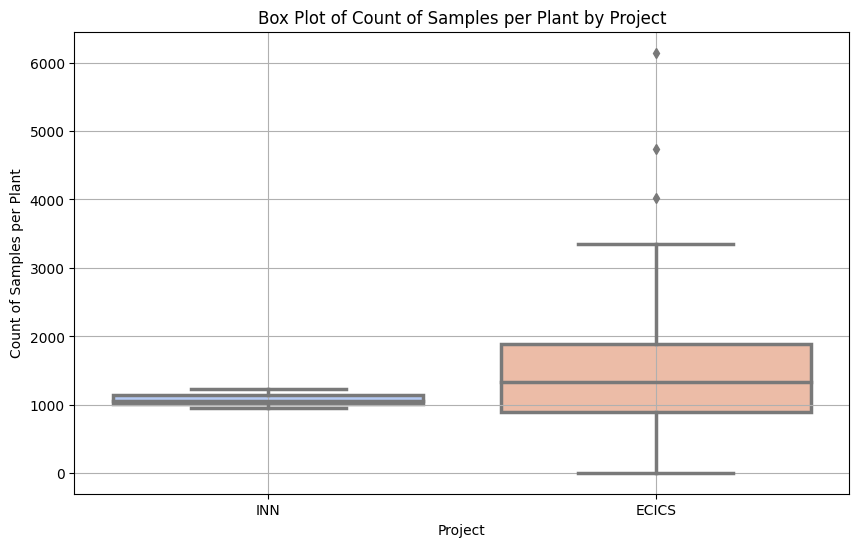

<IPython.core.display.Javascript object>

In [163]:
df_INN = pd.DataFrame(size_inn)
df_INN["Project"] = "INN"

df_CICS = pd.DataFrame(size_cics)
df_CICS["Project"] = "ECICS"

df_INN = df_INN.rename({0: "Samples"}, axis=1)
df_CICS = df_CICS.rename({0: "Samples"}, axis=1)

# Combine DataFrames
df_projects_size = pd.concat([df_INN, df_CICS], ignore_index=True)

plt.figure(figsize=(10, 6))
sns.boxplot(
    x="Project", y="Samples", data=df_projects_size, palette="coolwarm", linewidth=2.5
)
plt.title("Box Plot of Count of Samples per Plant by Project")
plt.xlabel("Project")
plt.ylabel("Count of Samples per Plant")
plt.grid(True)
plt.show()

/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_d

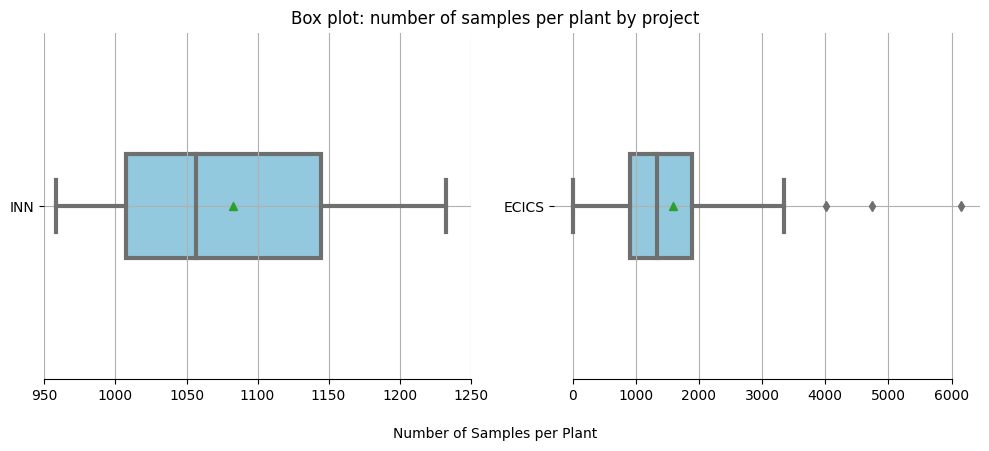

<IPython.core.display.Javascript object>

In [164]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_projects_size is your DataFrame with 'Project' and 'Samples' columns

# Create the figure and axes
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=False)  # 1 row, 2 columns

# Plot for INN (Project 1)
sns.boxplot(
    data=df_projects_size[df_projects_size["Project"] == "INN"],
    x="Samples",
    y="Project",
    # showfliers=False,  # Hide outliers
    linewidth=3,
    width=0.3,
    color="skyblue",
    showmeans=True,
    ax=axes[0],  # Assign to the first subplot
)

axes[0].set_xlim(950, 1250)
axes[0].set_xlabel("")
axes[0].set_ylabel("")
axes[0].grid(True)
sns.despine(trim=True, left=True, ax=axes[0])

# Plot for EMB (Project 2)
sns.boxplot(
    data=df_projects_size[df_projects_size["Project"] == "ECICS"],
    x="Samples",
    y="Project",
    # showfliers=False,  # Hide outliers
    linewidth=3,
    width=0.3,
    color="skyblue",
    showmeans=True,
    ax=axes[1],  # Assign to the second subplot
)

axes[1].set_xlabel("")
axes[1].set_ylabel("")
axes[1].grid(True)
sns.despine(trim=True, left=True, ax=axes[1])

# Adjust spacing between plots
plt.tight_layout()

# Set the overall title
plt.suptitle("Box plot: number of samples per plant by project", y=1.02)

# Add a single x-axis label
fig.text(0.5, -0.04, "Number of Samples per Plant", ha="center", va="center")

plt.show()

/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


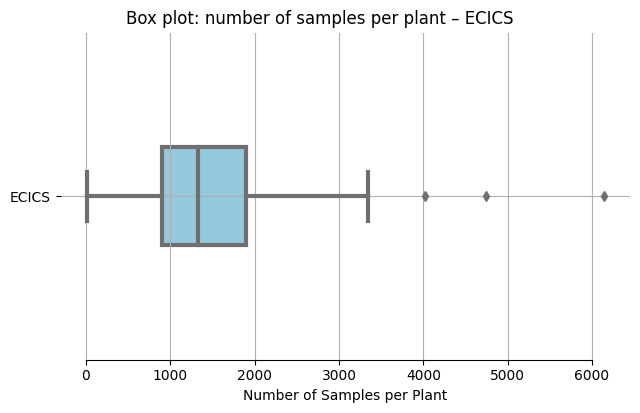

<IPython.core.display.Javascript object>

In [165]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_projects_size is your DataFrame with 'Project' and 'Samples' columns

# Create the figure and axes
fig, axes = plt.subplots(1, 1, figsize=(6.5, 4), sharex=False)  # 1 row, 2 columns

# Plot for EMB (Project 2)
sns.boxplot(
    data=df_projects_size[df_projects_size["Project"] == "ECICS"],
    x="Samples",
    y="Project",
    # showfliers=False,  # Hide outliers
    linewidth=3,
    width=0.3,
    color="skyblue",
    # showmeans=True,
    ax=axes,  # Assign to the second subplot
)

axes.set_xlabel("Number of Samples per Plant")
axes.set_ylabel("")
axes.grid(True)
sns.despine(trim=True, left=True, ax=axes)

# Adjust spacing between plots
plt.tight_layout()

# Set the overall title
plt.suptitle("Box plot: number of samples per plant – ECICS", y=1.02)

# Add a single x-axis label
# fig.text(0.5, -0.04, "Number of Samples per Plant", ha="center", va="center")

plt.show()

In [166]:
# import matplotlib.font_manager

<IPython.core.display.Javascript object>

In [167]:
# rcParams['font.family'] = 'serif'
# rcParams['font.serif'] = ['Libertinus']
# rcParams['font.monospace'] = ['Source Code Pro']
# rcParams['font.size'] = 12
from matplotlib import rcParams

rcParams["font.serif"]

['DejaVu Serif',
 'Bitstream Vera Serif',
 'Computer Modern Roman',
 'New Century Schoolbook',
 'Century Schoolbook L',
 'Utopia',
 'ITC Bookman',
 'Bookman',
 'Nimbus Roman No9 L',
 'Times New Roman',
 'Times',
 'Palatino',
 'Charter',
 'serif']

<IPython.core.display.Javascript object>

/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


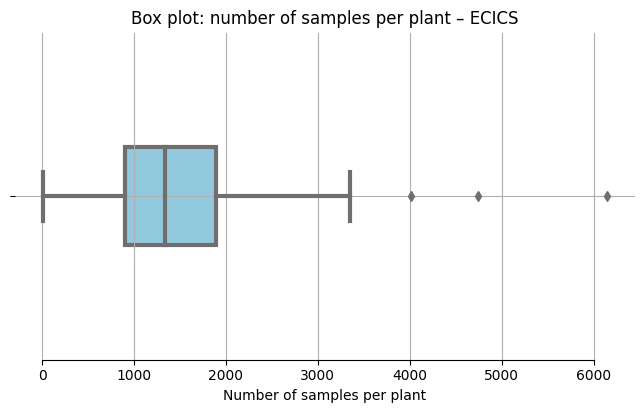

<IPython.core.display.Javascript object>

In [168]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Assuming df_projects_size is your DataFrame with 'Project' and 'Samples' columns

# Set the font to Latin Modern
# rcParams['font.family'] = 'serif'
# rcParams['font.serif'] = ['Libertinus']
# rcParams['font.monospace'] = ['Source Code Pro']
# rcParams['font.size'] = 12


data = df_projects_size[df_projects_size["Project"] == "ECICS"].copy()
data["Project"] = data["Project"].replace("ECICS", "")

# Create the figure and axes
fig, ax = plt.subplots(1, 1, figsize=(6.5, 4), sharex=False)  # 1 row, 1 column

# Plot for ECICS (Project 2)
sns.boxplot(
    data=data,
    x="Samples",
    y="Project",
    linewidth=3,
    width=0.3,
    color="skyblue",
    ax=ax,  # Assign to the subplot
)

ax.set_xlabel("Number of samples per plant")
ax.set_ylabel("")  # Remove the y-axis label
ax.grid(True)
sns.despine(trim=True, left=False, ax=ax)

# Adjust spacing between plots
plt.tight_layout()

# Set the overall title
plt.suptitle("Box plot: number of samples per plant – ECICS", y=1.02)

plt.savefig("plants_sample_dist_cics_2.png", dpi=300, bbox_inches='tight')

plt.show()


/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


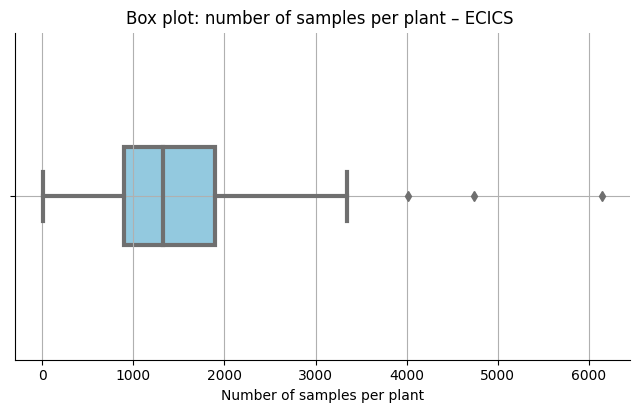

<IPython.core.display.Javascript object>

In [169]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Assuming df_projects_size is your DataFrame with 'Project' and 'Samples' columns

# Data selection and preparation
data = df_projects_size[df_projects_size["Project"] == "ECICS"].copy()
data["Project"] = data["Project"].replace("ECICS", "")

# Create the figure and axes
fig, ax = plt.subplots(1, 1, figsize=(6.5, 4), sharex=False)

# Box plot
sns.boxplot(
    data=data,
    x="Samples",
    y="Project",
    linewidth=3,
    width=0.3,
    color="skyblue",
    ax=ax,
)

ax.set_xlabel("Number of samples per plant")
ax.set_ylabel("")  # Remove the y-axis label
ax.grid(True)

# Explicitly control the spines
ax.spines['left'].set_visible(True)  # Ensure left spine is shown
ax.spines['top'].set_visible(False)  # Remove top spine (similar to sns.despine())
ax.spines['right'].set_visible(False)  # Hide the right spine (optional)
ax.spines['bottom'].set_visible(True)  # Keep the bottom spine

plt.tight_layout()

# Set the overall title
plt.suptitle("Box plot: number of samples per plant – ECICS", y=1.02)

plt.savefig("plants_sample_dist_cics_2.png", dpi=300, bbox_inches='tight')

plt.show()


/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


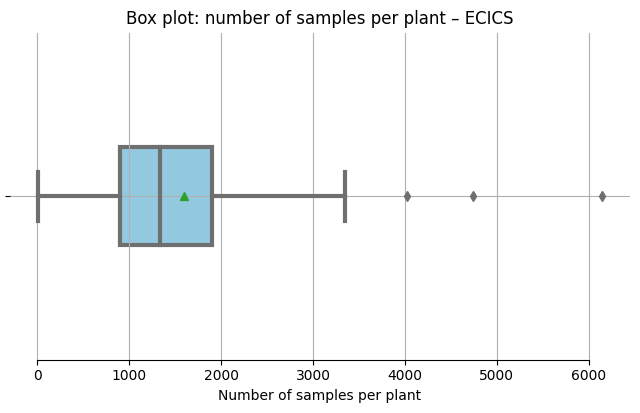

<IPython.core.display.Javascript object>

In [170]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Assuming df_projects_size is your DataFrame with 'Project' and 'Samples' columns

# Set the font to Latin Modern
# rcParams['font.family'] = 'serif'
# rcParams['font.serif'] = ['Libertinus']
# rcParams['font.monospace'] = ['Source Code Pro']
# rcParams['font.size'] = 12


data = df_projects_size[df_projects_size["Project"] == "ECICS"].copy()
data["Project"] = data["Project"].replace("ECICS", "")

# Create the figure and axes
fig, ax = plt.subplots(1, 1, figsize=(6.5, 4), sharex=False)  # 1 row, 1 column

# Plot for ECICS (Project 2)
sns.boxplot(
    data=data,
    x="Samples",
    y="Project",
    linewidth=3,
    width=0.3,
    color="skyblue",
    ax=ax,  # Assign to the subplot
    showmeans=True
)

ax.set_xlabel("Number of samples per plant")
ax.set_ylabel("")  # Remove the y-axis label
ax.grid(True)
sns.despine(trim=True, left=True, ax=ax)

# Adjust spacing between plots
plt.tight_layout()

# Set the overall title
plt.suptitle("Box plot: number of samples per plant – ECICS", y=1.02)

# plt.savefig("plants_sample_dist_cics_2.png", dpi=300, bbox_inches='tight')

plt.show()


In [171]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# from matplotlib import rcParams

# # Assuming df_projects_size is your DataFrame with 'Project' and 'Samples' columns

# # Set the font to Latin Modern
# # rcParams['font.family'] = 'serif'
# #rcParams['font.serif'] = ['Latin Modern']
# #rcParams['font.monospace'] = ['Source Code Pro']
# rcParams['font.size'] = 12

# rcParams['font.family'] = 'serif'
# rcParams['font.serif'] = ['Latin Modern Roman']


# data = df_projects_size[df_projects_size["Project"] == "ECICS"].copy()
# data["Project"] = data["Project"].replace("ECICS", "")

# # Create the figure and axes
# fig, ax = plt.subplots(1, 1, figsize=(6.5, 4), sharex=False)  # 1 row, 1 column

# # Plot for ECICS (Project 2)
# sns.boxplot(
#     data=data,
#     x="Samples",
#     y="Project",
#     linewidth=3,
#     width=0.3,
#     color="skyblue",
#     ax=ax,  # Assign to the subplot
# )

# ax.set_xlabel("Number of Samples per Plant")
# ax.set_ylabel("")  # Remove the y-axis label
# ax.grid(True)
# sns.despine(trim=True, left=True, ax=ax)

# # Adjust spacing between plots
# plt.tight_layout()

# # Set the overall title
# plt.suptitle("Box plot: number of samples per plant – ECICS", y=1.02)

# plt.show()


<IPython.core.display.Javascript object>

In [172]:
# data.to_excel("data.xlsx", index=False)

<IPython.core.display.Javascript object>

In [173]:
# import matplotlib.font_manager

# print(matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext="ttf"))

<IPython.core.display.Javascript object>

In [174]:
df["Factory_Plant"].apply(lambda x: x.split("_")[0]).value_counts()

Factory_Plant
209           30131
203           18522
204           15720
207            2996
partner_i     1233
206            1167
partner_ii     1057
Name: count, dtype: int64

<IPython.core.display.Javascript object>

In [175]:
df_projects_size_filter = df_projects_size[
    (df_projects_size["Project"] == "ECICS") & (df_projects_size["Samples"] < 4000)
].sort_values("Samples")

<IPython.core.display.Javascript object>

In [176]:
df_projects_size[df_projects_size["Project"] == "ECICS"].sort_values("Samples")

,Samples,Project
29,9,ECICS
30,138,ECICS
38,325,ECICS
23,355,ECICS
28,496,ECICS
44,499,ECICS
27,653,ECICS
34,709,ECICS
42,711,ECICS
22,763,ECICS


<IPython.core.display.Javascript object>

In [177]:
df_projects_size.describe()

,Samples
count,46.000000
mean,1560.521739
std,1183.321385
min,9.000000
25%,913.500000
50%,1277.500000
75%,1772.000000
max,6143.000000


<IPython.core.display.Javascript object>

In [178]:
df_projects_size_filter[["Samples"]].describe()

,Samples
count,40.000000
mean,1340.800000
std,771.109929
min,9.000000
25%,860.500000
50%,1244.500000
75%,1641.500000
max,3346.000000


<IPython.core.display.Javascript object>

In [179]:
df_all = pd.concat([df, df_partner_iv], axis=0).reset_index(drop=True)
df_all = df_all[df_all["CS28"].notna()]
df_all = df_all.dropna(axis=1, how="all")
df_all = df_all.reset_index(drop=True)
# df_all

<IPython.core.display.Javascript object>

In [180]:
df_all["CS28"].isna().sum()

0

<IPython.core.display.Javascript object>

In [181]:
df_all[df_all["CS28"].notna()]["CS28"].isna().sum()

0

<IPython.core.display.Javascript object>

In [182]:
# df_full = pd.concat([df_partner_iv, df], axis=0)
df_full = df_all.copy()
df_full["Factory_Plant"] = df_full["Factory_Plant"].fillna("partner_iv")

<IPython.core.display.Javascript object>

In [183]:
df_innovandi = df_full[
    df_full["Factory_Plant"].str.contains("partner_ii|partner_i|partner_iv")
]

df_cics = df_full[~df_full["Factory_Plant"].str.contains("partner_ii|partner_i|partner_iv")]

<IPython.core.display.Javascript object>

In [184]:
df_full["Factory_Plant"].apply(lambda x: x.split("_")[0]).value_counts()

Factory_Plant
209           30131
203           18522
204           15720
207            2996
partner_i     1233
206            1167
partner_ii     1057
partner_iv           958
Name: count, dtype: int64

<IPython.core.display.Javascript object>

In [185]:
# df_all = df_full.copy()
# index = df_all[df_all["Factory"] == "partner_ii"].index

# df_all.loc[index, "Sieve 32um"] = df_all.loc[index, "#400"].copy()
# df_all.loc[index, "Sieve 45um"] = df_all.loc[index, "#325"].copy()
# df_all.loc[index, "#400"] = np.nan
# df_all.loc[index, "#325"] = np.nan

<IPython.core.display.Javascript object>

In [186]:
df_all["Sieve 45 um"].isna().all()

False

<IPython.core.display.Javascript object>

In [187]:
df_all["Factory_Plant"]

0        203_AV
1        203_AV
2        203_AV
3        203_AV
4        203_AV
          ...  
71779       NaN
71780       NaN
71781       NaN
71782       NaN
71783       NaN
Name: Factory_Plant, Length: 71784, dtype: object

<IPython.core.display.Javascript object>

In [188]:
# df_innovandi = df_all[
#     df_all["Factory_Plant"].str.contains("partner_ii|partner_i|partner_iv")
# ]

# df_cics = df_all[~df_all["Factory_Plant"].str.contains("partner_ii|partner_i|partner_iv")]

<IPython.core.display.Javascript object>

In [189]:
CH_COLS = [
    "CaO",
    "MgO",
    "Na2O",
    "Al2O3",
    "SiO2",
    "SO3",
    "K2O",
    "TiO2",
    "Fe2O3",
    "Total Alkali as Na2O",
    "Loss on Ignition",
    "Insoluble Residue",
    "Cl-",
    "CO2",
    "Ca(OH)2",
    "CaCO3",
    "K2SO4",
]

<IPython.core.display.Javascript object>

In [190]:
M_COLS = [
    "Total C3S",
    "Total C2S",
    "Alpha C2S",
    "Beta C2S",
    "Gamma C2S",
    "C4AF",
    "C3A",
    "Cubic C3A",
    "Orthorhombic C3A",
    "Free CaO",
    "Portlandite",
    "Periclase",
    "Arcanite",
    "Aphthitalite",
    "Langbeinite",
    "Calcium sulfate",
    "Bassanite",
    "Anhydrite",
    "Calcite",
    "Dolomite",
    "Quartz",
    "Muscovite",
    "Gypsum",
]


<IPython.core.display.Javascript object>

#### Innovandi

In [191]:
(100 - df_innovandi[CH_COLS].isna().sum() / df_innovandi.shape[0] * 100).sort_values(
    ascending=False
).to_frame(name="Availability (%)").round(2).style.background_gradient(cmap="Reds")

,Availability (%)
SO3,99.380000
CaO,96.950000
Loss on Ignition,93.630000
MgO,69.920000
K2O,69.920000
Fe2O3,69.920000
SiO2,69.920000
Al2O3,69.920000
Na2O,69.920000
Insoluble Residue,37.680000


<IPython.core.display.Javascript object>

In [192]:
chemicals = (
    (100 - df_innovandi[CH_COLS].isna().sum() / df_innovandi.shape[0] * 100)
    .sort_values(ascending=False)
    .to_frame(name="Availability (%)")
    .round(2)
)

<IPython.core.display.Javascript object>

In [193]:
for var, value in zip(chemicals.index, chemicals.values):
    # print(var, value)
    s = f""" {var} &   & \% & XRD & {value[0]}\\\\"""
    print(s)

 SO3 &   & \% & XRD & 99.38\\
 CaO &   & \% & XRD & 96.95\\
 Loss on Ignition &   & \% & XRD & 93.63\\
 MgO &   & \% & XRD & 69.92\\
 K2O &   & \% & XRD & 69.92\\
 Fe2O3 &   & \% & XRD & 69.92\\
 SiO2 &   & \% & XRD & 69.92\\
 Al2O3 &   & \% & XRD & 69.92\\
 Na2O &   & \% & XRD & 69.92\\
 Insoluble Residue &   & \% & XRD & 37.68\\
 Cl- &   & \% & XRD & 29.5\\
 Total Alkali as Na2O &   & \% & XRD & 27.25\\
 Ca(OH)2 &   & \% & XRD & 27.03\\
 CaCO3 &   & \% & XRD & 27.03\\
 K2SO4 &   & \% & XRD & 27.03\\
 CO2 &   & \% & XRD & 27.0\\
 TiO2 &   & \% & XRD & 0.03\\


<IPython.core.display.Javascript object>

In [194]:
(100 - df_innovandi[M_COLS].isna().sum() / df_innovandi.shape[0] * 100).sort_values(
    ascending=False
).to_frame(name="Availability (%)").round(2).style.background_gradient(cmap="Reds")

,Availability (%)
Free CaO,95.970000
C4AF,95.840000
Total C3S,68.810000
C3A,68.810000
Cubic C3A,64.250000
Aphthitalite,64.250000
Orthorhombic C3A,64.250000
Periclase,64.250000
Beta C2S,64.250000
Quartz,64.220000


<IPython.core.display.Javascript object>

In [195]:
minerals = (
    (100 - df_innovandi[M_COLS].isna().sum() / df_innovandi.shape[0] * 100)
    .sort_values(ascending=False)
    .to_frame(name="Availability (%)")
    .round(2)
)

<IPython.core.display.Javascript object>

In [196]:
minerals.style.background_gradient(cmap="Reds")

,Availability (%)
Free CaO,95.970000
C4AF,95.840000
Total C3S,68.810000
C3A,68.810000
Cubic C3A,64.250000
Aphthitalite,64.250000
Orthorhombic C3A,64.250000
Periclase,64.250000
Beta C2S,64.250000
Quartz,64.220000


<IPython.core.display.Javascript object>

In [197]:
for var, value in zip(minerals.index, minerals.values):
    # print(var, value)
    s = f""" {var} &   & \% & XRD & {value[0]}\\\\"""
    print(s)

 Free CaO &   & \% & XRD & 95.97\\
 C4AF &   & \% & XRD & 95.84\\
 Total C3S &   & \% & XRD & 68.81\\
 C3A &   & \% & XRD & 68.81\\
 Cubic C3A &   & \% & XRD & 64.25\\
 Aphthitalite &   & \% & XRD & 64.25\\
 Orthorhombic C3A &   & \% & XRD & 64.25\\
 Periclase &   & \% & XRD & 64.25\\
 Beta C2S &   & \% & XRD & 64.25\\
 Quartz &   & \% & XRD & 64.22\\
 Gypsum &   & \% & XRD & 64.22\\
 Total C2S &   & \% & XRD & 56.8\\
 Langbeinite &   & \% & XRD & 38.89\\
 Gamma C2S &   & \% & XRD & 37.22\\
 Portlandite &   & \% & XRD & 37.22\\
 Arcanite &   & \% & XRD & 37.22\\
 Alpha C2S &   & \% & XRD & 37.22\\
 Bassanite &   & \% & XRD & 37.19\\
 Anhydrite &   & \% & XRD & 37.19\\
 Calcite &   & \% & XRD & 37.19\\
 Dolomite &   & \% & XRD & 37.19\\
 Muscovite &   & \% & XRD & 37.19\\
 Calcium sulfate &   & \% & XRD & 0.0\\


<IPython.core.display.Javascript object>

In [198]:
df_innovandi["CS28"].isna().sum()

0

<IPython.core.display.Javascript object>

In [199]:
physical = (
    (
        100
        - df_innovandi.drop(
            CH_COLS
            + M_COLS
            + [
                "Date",
                "Factory_Plant",
                "Cement_Type",
                "Calcium sulfate (composition)",
                "Cl",
            ],
            axis=1,
        )
        .isna()
        .sum()
        / df_innovandi.shape[0]
        * 100
    )
    .sort_values(ascending=False)
    .to_frame(name="Availability (%)")
    .round(2)
)
physical.style.background_gradient(cmap="Reds")

,Availability (%)
CS28,100.000000
Blaine,99.880000
CS3,71.090000
Initial setting time,70.500000
CS7,70.440000
CS1,69.060000
Soundness,63.980000
#325,37.960000
Density,37.960000
Final setting time,37.960000


<IPython.core.display.Javascript object>

In [200]:
for var, value in zip(physical.index, physical.values):
    # print(var, value)
    s = f""" {var} &   & \% & XRD & {value[0]}\\\\"""
    print(s)

 CS28 &   & \% & XRD & 100.0\\
 Blaine &   & \% & XRD & 99.88\\
 CS3 &   & \% & XRD & 71.09\\
 Initial setting time &   & \% & XRD & 70.5\\
 CS7 &   & \% & XRD & 70.44\\
 CS1 &   & \% & XRD & 69.06\\
 Soundness &   & \% & XRD & 63.98\\
 #325 &   & \% & XRD & 37.96\\
 Density &   & \% & XRD & 37.96\\
 Final setting time &   & \% & XRD & 37.96\\
 #200 &   & \% & XRD & 37.96\\
 %Gypsum &   & \% & XRD & 36.24\\
 %Clinker &   & \% & XRD & 36.24\\
 %Limestone &   & \% & XRD & 36.24\\
 Sieve 32 um &   & \% & XRD & 32.54\\
 Sieve 45 um &   & \% & XRD & 32.54\\
 Factory &   & \% & XRD & 29.5\\
 Sieve 24 um &   & \% & XRD & 29.4\\
 #400 &   & \% & XRD & 25.28\\
 Dehydration &   & \% & XRD & 24.45\\
 Specific Gravity &   & \% & XRD & 0.0\\


<IPython.core.display.Javascript object>

#### EMBRAPII CICS

In [201]:
# (
#     100
#     - df_cics[COLS].dropna(how="all", axis=1).isna().sum()
#     / df_cics.dropna(how="all", axis=1).shape[0]
#     * 100
# ).sort_values(ascending=False).to_frame(name="Availability (%)").round(
#     2
# ).style.background_gradient(
#     cmap="Reds"
# )

<IPython.core.display.Javascript object>

In [202]:
chemicals = (
    (100 - df_cics[CH_COLS].isna().sum() / df_cics.shape[0] * 100)
    .sort_values(ascending=False)
    .to_frame(name="Availability (%)")
    .round(2)
    .style.background_gradient(cmap="Reds")
)
chemicals

,Availability (%)
Loss on Ignition,99.240000
SO3,98.990000
MgO,97.000000
K2O,91.170000
Na2O,88.950000
CaO,76.190000
SiO2,76.070000
Al2O3,76.040000
Fe2O3,76.040000
Insoluble Residue,73.760000


<IPython.core.display.Javascript object>

In [203]:
chemicals = (
    (100 - df_cics[CH_COLS].isna().sum() / df_cics.shape[0] * 100)
    .sort_values(ascending=False)
    .to_frame(name="Availability (%)")
    .round(2)
)

<IPython.core.display.Javascript object>

In [204]:
for var, value in zip(chemicals.index, chemicals.values):
    # print(var, value)
    s = f""" {var} &   & \% & XRD & {value[0]}\\\\"""
    print(s)

 Loss on Ignition &   & \% & XRD & 99.24\\
 SO3 &   & \% & XRD & 98.99\\
 MgO &   & \% & XRD & 97.0\\
 K2O &   & \% & XRD & 91.17\\
 Na2O &   & \% & XRD & 88.95\\
 CaO &   & \% & XRD & 76.19\\
 SiO2 &   & \% & XRD & 76.07\\
 Al2O3 &   & \% & XRD & 76.04\\
 Fe2O3 &   & \% & XRD & 76.04\\
 Insoluble Residue &   & \% & XRD & 73.76\\
 TiO2 &   & \% & XRD & 14.06\\
 Total Alkali as Na2O &   & \% & XRD & 0.0\\
 Cl- &   & \% & XRD & 0.0\\
 CO2 &   & \% & XRD & 0.0\\
 Ca(OH)2 &   & \% & XRD & 0.0\\
 CaCO3 &   & \% & XRD & 0.0\\
 K2SO4 &   & \% & XRD & 0.0\\


<IPython.core.display.Javascript object>

In [205]:
(100 - df_cics[M_COLS].isna().sum() / df_cics.shape[0] * 100).sort_values(
    ascending=False
).to_frame(name="Availability (%)").round(2).style.background_gradient(cmap="Reds")

,Availability (%)
Free CaO,15.190000
Portlandite,13.590000
C4AF,13.020000
Dolomite,12.140000
Periclase,11.870000
Cubic C3A,11.640000
Orthorhombic C3A,11.640000
Bassanite,11.520000
Arcanite,11.050000
Calcite,11.050000


<IPython.core.display.Javascript object>

In [206]:
minerals = (
    (100 - df_cics[M_COLS].isna().sum() / df_cics.shape[0] * 100)
    .sort_values(ascending=False)
    .to_frame(name="Availability (%)")
    .round(2)
)

<IPython.core.display.Javascript object>

In [207]:
minerals.shape

(23, 1)

<IPython.core.display.Javascript object>

In [208]:
for var, value in zip(minerals.index, minerals.values):
    # print(var, value)
    s = f""" {var} &   & \% & XRD & {value[0]}\\\\"""
    print(s)

 Free CaO &   & \% & XRD & 15.19\\
 Portlandite &   & \% & XRD & 13.59\\
 C4AF &   & \% & XRD & 13.02\\
 Dolomite &   & \% & XRD & 12.14\\
 Periclase &   & \% & XRD & 11.87\\
 Cubic C3A &   & \% & XRD & 11.64\\
 Orthorhombic C3A &   & \% & XRD & 11.64\\
 Bassanite &   & \% & XRD & 11.52\\
 Arcanite &   & \% & XRD & 11.05\\
 Calcite &   & \% & XRD & 11.05\\
 Aphthitalite &   & \% & XRD & 10.93\\
 Quartz &   & \% & XRD & 10.71\\
 C3A &   & \% & XRD & 10.03\\
 Langbeinite &   & \% & XRD & 7.77\\
 Muscovite &   & \% & XRD & 6.5\\
 Total C3S &   & \% & XRD & 5.96\\
 Total C2S &   & \% & XRD & 4.78\\
 Anhydrite &   & \% & XRD & 3.8\\
 Beta C2S &   & \% & XRD & 2.41\\
 Gamma C2S &   & \% & XRD & 2.32\\
 Alpha C2S &   & \% & XRD & 2.32\\
 Calcium sulfate &   & \% & XRD & 0.89\\
 Gypsum &   & \% & XRD & 0.0\\


<IPython.core.display.Javascript object>

In [209]:
physical = (
    (
        100
        - df_cics.drop(
            CH_COLS
            + M_COLS
            + [
                "Date",
                "Factory_Plant",
                "Cement_Type",
                "Calcium sulfate (composition)",
                "Cl",
            ],
            axis=1,
        )
        .isna()
        .sum()
        / df_cics.shape[0]
        * 100
    )
    .sort_values(ascending=False)
    .to_frame(name="Availability (%)")
    .round(2)
)
physical

,Availability (%)
CS28,100.00
CS7,99.86
Blaine,99.68
Final setting time,98.83
#200,95.96
Initial setting time,95.89
CS3,94.00
#325,86.60
CS1,49.12
#400,20.80


<IPython.core.display.Javascript object>

In [210]:
for var, value in zip(physical.index, physical.values):
    # print(var, value)
    s = f""" {var} &   & \% & XRD & {value[0]}\\\\"""
    print(s)

 CS28 &   & \% & XRD & 100.0\\
 CS7 &   & \% & XRD & 99.86\\
 Blaine &   & \% & XRD & 99.68\\
 Final setting time &   & \% & XRD & 98.83\\
 #200 &   & \% & XRD & 95.96\\
 Initial setting time &   & \% & XRD & 95.89\\
 CS3 &   & \% & XRD & 94.0\\
 #325 &   & \% & XRD & 86.6\\
 CS1 &   & \% & XRD & 49.12\\
 #400 &   & \% & XRD & 20.8\\
 Specific Gravity &   & \% & XRD & 14.17\\
 %Clinker &   & \% & XRD & 0.0\\
 Sieve 24 um &   & \% & XRD & 0.0\\
 Density &   & \% & XRD & 0.0\\
 Dehydration &   & \% & XRD & 0.0\\
 Sieve 45 um &   & \% & XRD & 0.0\\
 %Limestone &   & \% & XRD & 0.0\\
 %Gypsum &   & \% & XRD & 0.0\\
 Soundness &   & \% & XRD & 0.0\\
 Sieve 32 um &   & \% & XRD & 0.0\\
 Factory &   & \% & XRD & 0.0\\


<IPython.core.display.Javascript object>

# CS28 Analysis

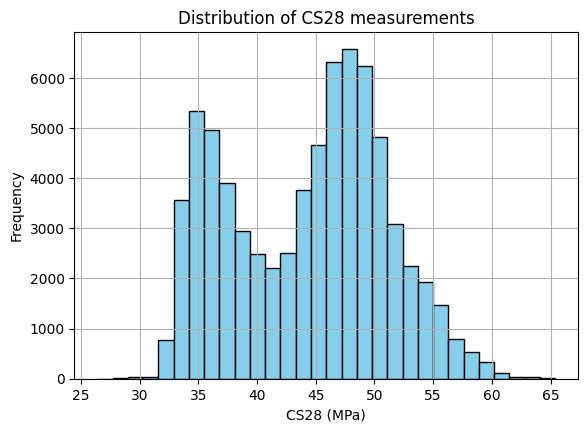

<IPython.core.display.Javascript object>

In [211]:
plt.figure(figsize=(6.5, 4.5))
plt.hist(df_all["CS28"], bins=30, linewidth=1, color="skyblue", edgecolor="black")
plt.title("Distribution of CS28 measurements")
plt.xlabel("CS28 (MPa)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


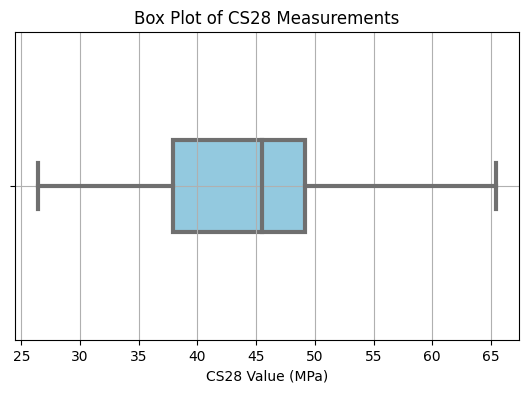

<IPython.core.display.Javascript object>

In [212]:
plt.figure(figsize=(6.5, 4))
sns.boxplot(x=df_all["CS28"], linewidth=3, width=0.3, color="skyblue")
plt.title("Box Plot of CS28 Measurements")
plt.xlabel("CS28 Value (MPa)")
plt.grid(True)
plt.show()


In [213]:
df_innovandi = df_innovandi.reset_index(drop=True)
df_cics = df_cics.reset_index(drop=True)
df_innovandi["Project"] = "INN"
df_cics["Project"] = "ECICS"

<IPython.core.display.Javascript object>

In [214]:
df_innovandi[["CS28"]].describe()

,CS28
count,3248.000000
mean,44.980074
std,5.794638
min,32.400002
25%,40.557500
50%,45.295000
75%,48.407501
max,65.400000


<IPython.core.display.Javascript object>

In [215]:
df_innovandi[["CS28"]].mode()

,CS28
0,46.5


<IPython.core.display.Javascript object>

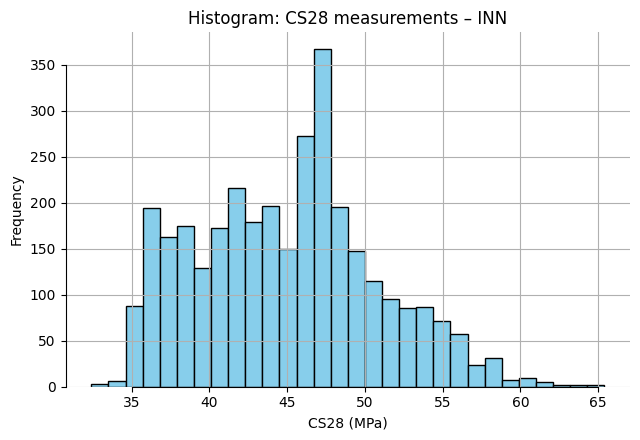

<IPython.core.display.Javascript object>

In [216]:
plt.figure(figsize=(6.5, 4.5))
plt.hist(df_innovandi["CS28"], bins=30, linewidth=1, color="skyblue", edgecolor="black")
plt.title("Histogram: CS28 measurements – INN")
plt.xlabel("CS28 (MPa)")
plt.ylabel("Frequency")
plt.grid(True)
sns.despine(trim=True, left=False)
plt.tight_layout()
plt.savefig("cs28_histogram_inn_with_label.png", dpi=300, bbox_inches="tight")
plt.show()

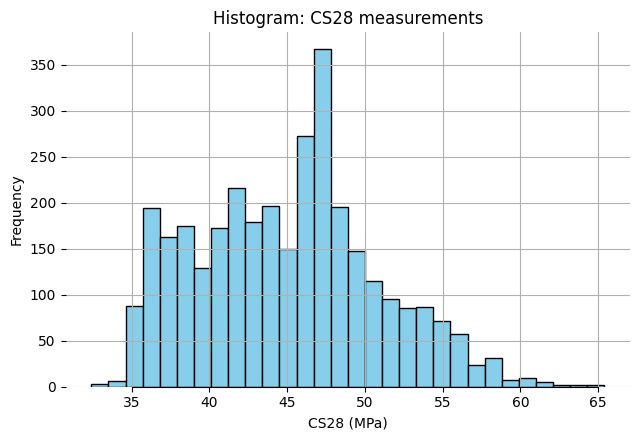

<IPython.core.display.Javascript object>

In [217]:
plt.figure(figsize=(6.5, 4.5))
plt.hist(df_innovandi["CS28"], bins=30, linewidth=1, color="skyblue", edgecolor="black")
plt.title("Histogram: CS28 measurements")
plt.xlabel("CS28 (MPa)")
plt.ylabel("Frequency")
plt.grid(True)
sns.despine(trim=True, left=True)
plt.tight_layout()
plt.show()

In [218]:
df_cics[["CS28"]].describe()

,CS28
count,68536.000000
mean,44.260901
std,6.738682
min,26.400000
25%,37.700001
50%,45.500000
75%,49.200001
max,64.700000


<IPython.core.display.Javascript object>

In [219]:
df_cics[["CS28"]].mode()

,CS28
0,47.0


<IPython.core.display.Javascript object>

In [220]:
import seaborn as sns
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>

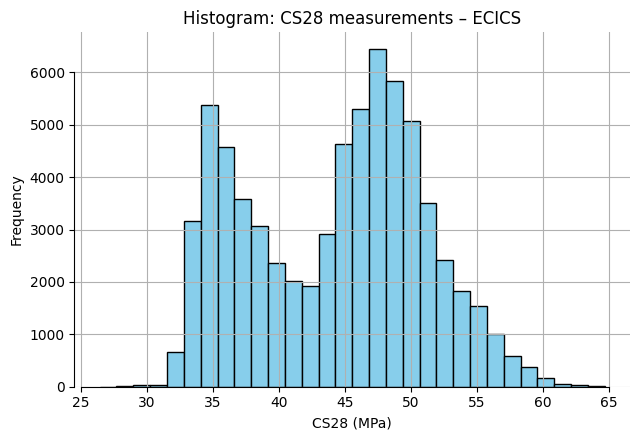

<IPython.core.display.Javascript object>

In [221]:
plt.figure(figsize=(6.5, 4.5))
plt.hist(df_cics["CS28"], bins=30, linewidth=1, color="skyblue", edgecolor="black")
plt.title("Histogram: CS28 measurements – ECICS")
plt.xlabel("CS28 (MPa)")
plt.ylabel("Frequency")
plt.grid(True)
sns.despine(trim=True, left=False)
# Adjust spacing between plots
plt.tight_layout()
plt.savefig("cs28_histogram_cics_with_label.png", dpi=300, bbox_inches="tight")
plt.show()

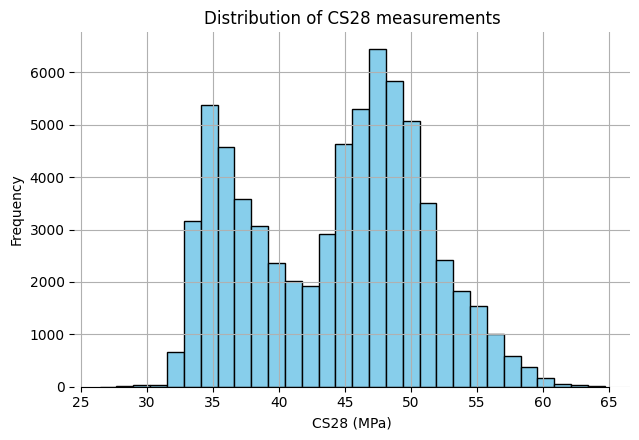

<IPython.core.display.Javascript object>

In [222]:
plt.figure(figsize=(6.5, 4.5))
plt.hist(df_cics["CS28"], bins=30, linewidth=1, color="skyblue", edgecolor="black")
plt.title("Distribution of CS28 measurements")
plt.xlabel("CS28 (MPa)")
plt.ylabel("Frequency")
plt.grid(True)
sns.despine(trim=True, left=True)
# Adjust spacing between plots
plt.tight_layout()
plt.show()

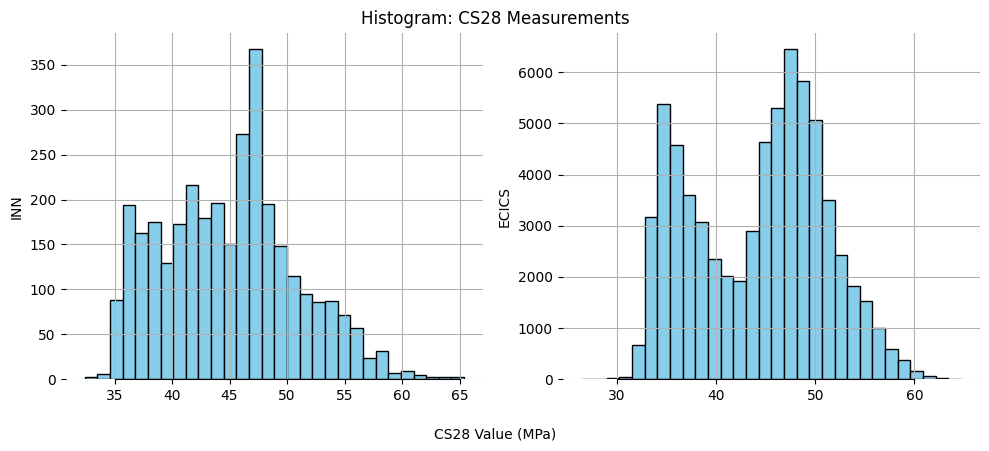

<IPython.core.display.Javascript object>

In [223]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_projects_size is your DataFrame with 'Project' and 'Samples' columns

# Create the figure and axes
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=False)  # 1 row, 2 columns

# Plot for INN (Project 1)

axes[0].hist(
    x="CS28",
    label="Project",
    data=df_innovandi,
    bins=30,
    linewidth=1,
    color="skyblue",
    edgecolor="black",
    # ax=axes[0],  # Assign to the first subplot
)


# axes[0].set_xlim(30, 66)
# axes[0].set_xlabel("")
axes[0].set_ylabel("INN")
axes[0].grid(True)
sns.despine(trim=True, left=True, ax=axes[0])

axes[1].hist(
    x="CS28",
    label="Project",
    data=df_cics,
    bins=30,
    linewidth=1,
    color="skyblue",
    edgecolor="black",
    # ax=axes[1],  # Assign to the first subplot
)

# axes[1].set_xlim(20, 70)
# axes[1].set_xlabel("")
axes[1].set_ylabel("ECICS")
axes[1].grid(True)
sns.despine(trim=True, left=True, ax=axes[1])

# Adjust spacing between plots
plt.tight_layout()

# Set the overall title
plt.suptitle("Histogram: CS28 Measurements", y=1.02)

# Add a single x-axis label
fig.text(0.5, -0.04, "CS28 Value (MPa)", ha="center", va="center")

plt.show()

/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_d

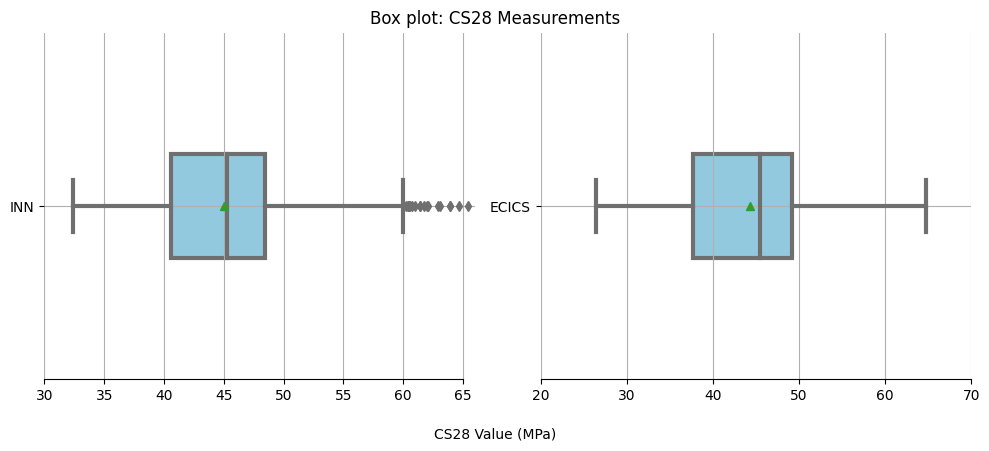

<IPython.core.display.Javascript object>

In [224]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_projects_size is your DataFrame with 'Project' and 'Samples' columns

# Create the figure and axes
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=False)  # 1 row, 2 columns

# Plot for INN (Project 1)
sns.boxplot(
    data=df_innovandi,
    x="CS28",
    y="Project",
    # showfliers=False,  # Hide outliers
    linewidth=3,
    width=0.3,
    color="skyblue",
    showmeans=True,
    ax=axes[0],  # Assign to the first subplot
)

axes[0].set_xlim(30, 66)
axes[0].set_xlabel("")
axes[0].set_ylabel("")
axes[0].grid(True)
sns.despine(trim=True, left=True, ax=axes[0])

# Plot for EMB (Project 2)
sns.boxplot(
    data=df_cics,
    x="CS28",
    y="Project",
    # showfliers=False,  # Hide outliers
    linewidth=3,
    width=0.3,
    color="skyblue",
    showmeans=True,
    ax=axes[1],  # Assign to the first subplot
)
axes[1].set_xlim(20, 70)
axes[1].set_xlabel("")
axes[1].set_ylabel("")
axes[1].grid(True)
sns.despine(trim=True, left=True, ax=axes[1])

# Adjust spacing between plots
plt.tight_layout()

# Set the overall title
plt.suptitle("Box plot: CS28 Measurements", y=1.02)

# Add a single x-axis label
fig.text(0.5, -0.04, "CS28 Value (MPa)", ha="center", va="center")

plt.show()

In [225]:
df_cics["CS28"].min(), df_cics["CS28"].max()

(26.3999996185303, 64.7)

<IPython.core.display.Javascript object>

### Dropping rows with negative values

In [226]:
# df[df.drop(["Date"], axis=1).duplicated()].drop("Date", axis=1).select_dtypes(
#     include="number"
# ).apply(lambda x: x < 0).sum().sort_values(ascending=False)

<IPython.core.display.Javascript object>

In [227]:
df.shape

(70826, 66)

<IPython.core.display.Javascript object>

In [228]:
df.drop("Date", axis=1).select_dtypes(include="number").apply(
    lambda x: x < 0
).sum().sort_values(ascending=False)

Na2O                             874
CaO                                0
Dolomite                           0
C3A                                0
Cubic C3A                          0
                                ... 
Calcined clay                      0
Calcium sulfate (composition)      0
Total C3S                          0
Total C2S                          0
Density                            0
Length: 63, dtype: int64

<IPython.core.display.Javascript object>

In [229]:
df[
    df.drop("Date", axis=1)
    .select_dtypes(include="number")
    .apply(lambda x: x < 0)
    .any(axis=1)
]["Factory_Plant"].value_counts()

Factory_Plant
207_AT    776
203_C      56
209_AP     29
209_AM      9
209_L       3
209_V       1
Name: count, dtype: int64

<IPython.core.display.Javascript object>

In [230]:
index = df[
    df.drop("Date", axis=1)
    .select_dtypes(include="number")
    .apply(lambda x: x < 0)
    .any(axis=1)
].index

df = df.drop(index).reset_index(drop=True)

<IPython.core.display.Javascript object>

In [231]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69952 entries, 0 to 69951
Data columns (total 66 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Date                           69952 non-null  datetime64[ns]
 1   CaO                            53617 non-null  float64       
 2   MgO                            67880 non-null  float64       
 3   Na2O                           62362 non-null  float64       
 4   Al2O3                          53514 non-null  float64       
 5   SiO2                           53530 non-null  float64       
 6   SO3                            69243 non-null  float64       
 7   K2O                            63883 non-null  float64       
 8   TiO2                           9583 non-null   float64       
 9   Fe2O3                          53509 non-null  float64       
 10  Loss on Ignition               69422 non-null  float64       
 11  Insoluble Resid

<IPython.core.display.Javascript object>

### Reseting the index

In [232]:
df = df.reset_index(drop=True)

<IPython.core.display.Javascript object>

### Sort the dataset by date

In [233]:
# We first make sure Date column was infered correctly
df["Date"].dtype

dtype('<M8[ns]')

<IPython.core.display.Javascript object>

In [234]:
df["Date"] = df["Date"].dt.date

<IPython.core.display.Javascript object>

In [235]:
df = df.sort_values(by="Date")

<IPython.core.display.Javascript object>

In [236]:
df = df.reset_index(drop=True)

<IPython.core.display.Javascript object>

In [237]:
df = df.iloc[1:].reset_index(drop=True)

<IPython.core.display.Javascript object>

## Saving the dataset

<h3>Saving for feature engineering</h3>

In [238]:
# df.to_csv("../../../../data/interim/Global-Dataset/global_dataset.csv", index=False)

<IPython.core.display.Javascript object>

In [239]:
df.shape

(69951, 66)

<IPython.core.display.Javascript object>

In [240]:
df["Factory_Plant"].apply(lambda x: x.split("_")[0]).value_counts()

Factory_Plant
209           30089
203           18465
204           15720
207            2220
partner_i     1233
206            1167
partner_ii     1057
Name: count, dtype: int64

<IPython.core.display.Javascript object>